In [1]:
#import libraries
import os
import torch
import math
import random
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import vgg19
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import torch

model_path = "/content/drive/MyDrive/GFPGAN/pretrained/final.pth"
model_dict = torch.load(model_path, map_location="cpu")

print(model_dict.keys())  # Check what is stored inside

# g_ema -> exponential moving average of Generator. It is a smoother, more stable version of the generator.
# During training, it is updated slowly using an EMA formula. This prevents the model from changing too fast due to noisy updates
#α (decay factor) is usually 0.999 or 0.9999.

# 𝑔_ema = 𝛼.g_ema + (1-𝛼).G

<ipython-input-3-3c39c3f67c13>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(model_path, map_location="cpu")


dict_keys(['G', 'g_ema', 'g_optim', 'D', 'd_optim', 'args', 'left_eye_d', 'right_eye_d', 'mouth_d'])


In [4]:
# #Degradations.py
# import cv2
# import math
# import numpy as np
# import random
# import torch
# from scipy import special
# from scipy.stats import multivariate_normal
# # from torchvision.transforms.functional_tensor import rgb_to_grayscale

# # -------------------------------------------------------------------- #
# # --------------------------- blur kernels --------------------------- #
# # -------------------------------------------------------------------- #


# # --------------------------- util functions --------------------------- #
# def sigma_matrix2(sig_x, sig_y, theta):
#     """Calculate the rotated sigma matrix (two dimensional matrix).

#     Args:
#         sig_x (float):
#         sig_y (float):
#         theta (float): Radian measurement.

#     Returns:
#         ndarray: Rotated sigma matrix.
#     """
#     d_matrix = np.array([[sig_x**2, 0], [0, sig_y**2]])
#     u_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
#     return np.dot(u_matrix, np.dot(d_matrix, u_matrix.T))


# def mesh_grid(kernel_size):
#     """Generate the mesh grid, centering at zero.

#     Args:
#         kernel_size (int):

#     Returns:
#         xy (ndarray): with the shape (kernel_size, kernel_size, 2)
#         xx (ndarray): with the shape (kernel_size, kernel_size)
#         yy (ndarray): with the shape (kernel_size, kernel_size)
#     """
#     ax = np.arange(-kernel_size // 2 + 1., kernel_size // 2 + 1.)
#     xx, yy = np.meshgrid(ax, ax)
#     xy = np.hstack((xx.reshape((kernel_size * kernel_size, 1)), yy.reshape(kernel_size * kernel_size,
#                                                                            1))).reshape(kernel_size, kernel_size, 2)
#     return xy, xx, yy


# def pdf2(sigma_matrix, grid):
#     """Calculate PDF of the bivariate Gaussian distribution.

#     Args:
#         sigma_matrix (ndarray): with the shape (2, 2)
#         grid (ndarray): generated by :func:`mesh_grid`,
#             with the shape (K, K, 2), K is the kernel size.

#     Returns:
#         kernel (ndarrray): un-normalized kernel.
#     """
#     inverse_sigma = np.linalg.inv(sigma_matrix)
#     kernel = np.exp(-0.5 * np.sum(np.dot(grid, inverse_sigma) * grid, 2))
#     return kernel


# def cdf2(d_matrix, grid):
#     """Calculate the CDF of the standard bivariate Gaussian distribution.
#         Used in skewed Gaussian distribution.

#     Args:
#         d_matrix (ndarrasy): skew matrix.
#         grid (ndarray): generated by :func:`mesh_grid`,
#             with the shape (K, K, 2), K is the kernel size.

#     Returns:
#         cdf (ndarray): skewed cdf.
#     """
#     rv = multivariate_normal([0, 0], [[1, 0], [0, 1]])
#     grid = np.dot(grid, d_matrix)
#     cdf = rv.cdf(grid)
#     return cdf


# def bivariate_Gaussian(kernel_size, sig_x, sig_y, theta, grid=None, isotropic=True):
#     """Generate a bivariate isotropic or anisotropic Gaussian kernel.

#     In the isotropic mode, only `sig_x` is used. `sig_y` and `theta` is ignored.

#     Args:
#         kernel_size (int):
#         sig_x (float):
#         sig_y (float):
#         theta (float): Radian measurement.
#         grid (ndarray, optional): generated by :func:`mesh_grid`,
#             with the shape (K, K, 2), K is the kernel size. Default: None
#         isotropic (bool):

#     Returns:
#         kernel (ndarray): normalized kernel.
#     """
#     if grid is None:
#         grid, _, _ = mesh_grid(kernel_size)
#     if isotropic:
#         sigma_matrix = np.array([[sig_x**2, 0], [0, sig_x**2]])
#     else:
#         sigma_matrix = sigma_matrix2(sig_x, sig_y, theta)
#     kernel = pdf2(sigma_matrix, grid)
#     kernel = kernel / np.sum(kernel)
#     return kernel


# def bivariate_generalized_Gaussian(kernel_size, sig_x, sig_y, theta, beta, grid=None, isotropic=True):
#     """Generate a bivariate generalized Gaussian kernel.
#         Described in `Parameter Estimation For Multivariate Generalized
#         Gaussian Distributions`_
#         by Pascal et. al (2013).

#     In the isotropic mode, only `sig_x` is used. `sig_y` and `theta` is ignored.

#     Args:
#         kernel_size (int):
#         sig_x (float):
#         sig_y (float):
#         theta (float): Radian measurement.
#         beta (float): shape parameter, beta = 1 is the normal distribution.
#         grid (ndarray, optional): generated by :func:`mesh_grid`,
#             with the shape (K, K, 2), K is the kernel size. Default: None

#     Returns:
#         kernel (ndarray): normalized kernel.

#     .. _Parameter Estimation For Multivariate Generalized Gaussian
#     Distributions: https://arxiv.org/abs/1302.6498
#     """
#     if grid is None:
#         grid, _, _ = mesh_grid(kernel_size)
#     if isotropic:
#         sigma_matrix = np.array([[sig_x**2, 0], [0, sig_x**2]])
#     else:
#         sigma_matrix = sigma_matrix2(sig_x, sig_y, theta)
#     inverse_sigma = np.linalg.inv(sigma_matrix)
#     kernel = np.exp(-0.5 * np.power(np.sum(np.dot(grid, inverse_sigma) * grid, 2), beta))
#     kernel = kernel / np.sum(kernel)
#     return kernel


# def bivariate_plateau(kernel_size, sig_x, sig_y, theta, beta, grid=None, isotropic=True):
#     """Generate a plateau-like anisotropic kernel.
#     1 / (1+x^(beta))

#     Ref: https://stats.stackexchange.com/questions/203629/is-there-a-plateau-shaped-distribution

#     In the isotropic mode, only `sig_x` is used. `sig_y` and `theta` is ignored.

#     Args:
#         kernel_size (int):
#         sig_x (float):
#         sig_y (float):
#         theta (float): Radian measurement.
#         beta (float): shape parameter, beta = 1 is the normal distribution.
#         grid (ndarray, optional): generated by :func:`mesh_grid`,
#             with the shape (K, K, 2), K is the kernel size. Default: None

#     Returns:
#         kernel (ndarray): normalized kernel.
#     """
#     if grid is None:
#         grid, _, _ = mesh_grid(kernel_size)
#     if isotropic:
#         sigma_matrix = np.array([[sig_x**2, 0], [0, sig_x**2]])
#     else:
#         sigma_matrix = sigma_matrix2(sig_x, sig_y, theta)
#     inverse_sigma = np.linalg.inv(sigma_matrix)
#     kernel = np.reciprocal(np.power(np.sum(np.dot(grid, inverse_sigma) * grid, 2), beta) + 1)
#     kernel = kernel / np.sum(kernel)
#     return kernel


# def random_bivariate_Gaussian(kernel_size,
#                               sigma_x_range,
#                               sigma_y_range,
#                               rotation_range,
#                               noise_range=None,
#                               isotropic=True):
#     """Randomly generate bivariate isotropic or anisotropic Gaussian kernels.

#     In the isotropic mode, only `sigma_x_range` is used. `sigma_y_range` and `rotation_range` is ignored.

#     Args:
#         kernel_size (int):
#         sigma_x_range (tuple): [0.6, 5]
#         sigma_y_range (tuple): [0.6, 5]
#         rotation range (tuple): [-math.pi, math.pi]
#         noise_range(tuple, optional): multiplicative kernel noise,
#             [0.75, 1.25]. Default: None

#     Returns:
#         kernel (ndarray):
#     """
#     assert kernel_size % 2 == 1, 'Kernel size must be an odd number.'
#     assert sigma_x_range[0] < sigma_x_range[1], 'Wrong sigma_x_range.'
#     sigma_x = np.random.uniform(sigma_x_range[0], sigma_x_range[1])
#     if isotropic is False:
#         assert sigma_y_range[0] < sigma_y_range[1], 'Wrong sigma_y_range.'
#         assert rotation_range[0] < rotation_range[1], 'Wrong rotation_range.'
#         sigma_y = np.random.uniform(sigma_y_range[0], sigma_y_range[1])
#         rotation = np.random.uniform(rotation_range[0], rotation_range[1])
#     else:
#         sigma_y = sigma_x
#         rotation = 0

#     kernel = bivariate_Gaussian(kernel_size, sigma_x, sigma_y, rotation, isotropic=isotropic)

#     # add multiplicative noise
#     if noise_range is not None:
#         assert noise_range[0] < noise_range[1], 'Wrong noise range.'
#         noise = np.random.uniform(noise_range[0], noise_range[1], size=kernel.shape)
#         kernel = kernel * noise
#     kernel = kernel / np.sum(kernel)
#     return kernel


# def random_bivariate_generalized_Gaussian(kernel_size,
#                                           sigma_x_range,
#                                           sigma_y_range,
#                                           rotation_range,
#                                           beta_range,
#                                           noise_range=None,
#                                           isotropic=True):
#     """Randomly generate bivariate generalized Gaussian kernels.

#     In the isotropic mode, only `sigma_x_range` is used. `sigma_y_range` and `rotation_range` is ignored.

#     Args:
#         kernel_size (int):
#         sigma_x_range (tuple): [0.6, 5]
#         sigma_y_range (tuple): [0.6, 5]
#         rotation range (tuple): [-math.pi, math.pi]
#         beta_range (tuple): [0.5, 8]
#         noise_range(tuple, optional): multiplicative kernel noise,
#             [0.75, 1.25]. Default: None

#     Returns:
#         kernel (ndarray):
#     """
#     assert kernel_size % 2 == 1, 'Kernel size must be an odd number.'
#     assert sigma_x_range[0] < sigma_x_range[1], 'Wrong sigma_x_range.'
#     sigma_x = np.random.uniform(sigma_x_range[0], sigma_x_range[1])
#     if isotropic is False:
#         assert sigma_y_range[0] < sigma_y_range[1], 'Wrong sigma_y_range.'
#         assert rotation_range[0] < rotation_range[1], 'Wrong rotation_range.'
#         sigma_y = np.random.uniform(sigma_y_range[0], sigma_y_range[1])
#         rotation = np.random.uniform(rotation_range[0], rotation_range[1])
#     else:
#         sigma_y = sigma_x
#         rotation = 0

#     # assume beta_range[0] < 1 < beta_range[1]
#     if np.random.uniform() < 0.5:
#         beta = np.random.uniform(beta_range[0], 1)
#     else:
#         beta = np.random.uniform(1, beta_range[1])

#     kernel = bivariate_generalized_Gaussian(kernel_size, sigma_x, sigma_y, rotation, beta, isotropic=isotropic)

#     # add multiplicative noise
#     if noise_range is not None:
#         assert noise_range[0] < noise_range[1], 'Wrong noise range.'
#         noise = np.random.uniform(noise_range[0], noise_range[1], size=kernel.shape)
#         kernel = kernel * noise
#     kernel = kernel / np.sum(kernel)
#     return kernel


# def random_bivariate_plateau(kernel_size,
#                              sigma_x_range,
#                              sigma_y_range,
#                              rotation_range,
#                              beta_range,
#                              noise_range=None,
#                              isotropic=True):
#     """Randomly generate bivariate plateau kernels.

#     In the isotropic mode, only `sigma_x_range` is used. `sigma_y_range` and `rotation_range` is ignored.

#     Args:
#         kernel_size (int):
#         sigma_x_range (tuple): [0.6, 5]
#         sigma_y_range (tuple): [0.6, 5]
#         rotation range (tuple): [-math.pi/2, math.pi/2]
#         beta_range (tuple): [1, 4]
#         noise_range(tuple, optional): multiplicative kernel noise,
#             [0.75, 1.25]. Default: None

#     Returns:
#         kernel (ndarray):
#     """
#     assert kernel_size % 2 == 1, 'Kernel size must be an odd number.'
#     assert sigma_x_range[0] < sigma_x_range[1], 'Wrong sigma_x_range.'
#     sigma_x = np.random.uniform(sigma_x_range[0], sigma_x_range[1])
#     if isotropic is False:
#         assert sigma_y_range[0] < sigma_y_range[1], 'Wrong sigma_y_range.'
#         assert rotation_range[0] < rotation_range[1], 'Wrong rotation_range.'
#         sigma_y = np.random.uniform(sigma_y_range[0], sigma_y_range[1])
#         rotation = np.random.uniform(rotation_range[0], rotation_range[1])
#     else:
#         sigma_y = sigma_x
#         rotation = 0

#     # TODO: this may be not proper
#     if np.random.uniform() < 0.5:
#         beta = np.random.uniform(beta_range[0], 1)
#     else:
#         beta = np.random.uniform(1, beta_range[1])

#     kernel = bivariate_plateau(kernel_size, sigma_x, sigma_y, rotation, beta, isotropic=isotropic)
#     # add multiplicative noise
#     if noise_range is not None:
#         assert noise_range[0] < noise_range[1], 'Wrong noise range.'
#         noise = np.random.uniform(noise_range[0], noise_range[1], size=kernel.shape)
#         kernel = kernel * noise
#     kernel = kernel / np.sum(kernel)

#     return kernel


# def random_mixed_kernels(kernel_list,
#                          kernel_prob,
#                          kernel_size=21,
#                          sigma_x_range=(0.6, 5),
#                          sigma_y_range=(0.6, 5),
#                          rotation_range=(-math.pi, math.pi),
#                          betag_range=(0.5, 8),
#                          betap_range=(0.5, 8),
#                          noise_range=None):
#     """Randomly generate mixed kernels.

#     Args:
#         kernel_list (tuple): a list name of kernel types,
#             support ['iso', 'aniso', 'skew', 'generalized', 'plateau_iso',
#             'plateau_aniso']
#         kernel_prob (tuple): corresponding kernel probability for each
#             kernel type
#         kernel_size (int):
#         sigma_x_range (tuple): [0.6, 5]
#         sigma_y_range (tuple): [0.6, 5]
#         rotation range (tuple): [-math.pi, math.pi]
#         beta_range (tuple): [0.5, 8]
#         noise_range(tuple, optional): multiplicative kernel noise,
#             [0.75, 1.25]. Default: None

#     Returns:
#         kernel (ndarray):
#     """
#     kernel_type = random.choices(kernel_list, kernel_prob)[0]
#     if kernel_type == 'iso':
#         kernel = random_bivariate_Gaussian(
#             kernel_size, sigma_x_range, sigma_y_range, rotation_range, noise_range=noise_range, isotropic=True)
#     elif kernel_type == 'aniso':
#         kernel = random_bivariate_Gaussian(
#             kernel_size, sigma_x_range, sigma_y_range, rotation_range, noise_range=noise_range, isotropic=False)
#     elif kernel_type == 'generalized_iso':
#         kernel = random_bivariate_generalized_Gaussian(
#             kernel_size,
#             sigma_x_range,
#             sigma_y_range,
#             rotation_range,
#             betag_range,
#             noise_range=noise_range,
#             isotropic=True)
#     elif kernel_type == 'generalized_aniso':
#         kernel = random_bivariate_generalized_Gaussian(
#             kernel_size,
#             sigma_x_range,
#             sigma_y_range,
#             rotation_range,
#             betag_range,
#             noise_range=noise_range,
#             isotropic=False)
#     elif kernel_type == 'plateau_iso':
#         kernel = random_bivariate_plateau(
#             kernel_size, sigma_x_range, sigma_y_range, rotation_range, betap_range, noise_range=None, isotropic=True)
#     elif kernel_type == 'plateau_aniso':
#         kernel = random_bivariate_plateau(
#             kernel_size, sigma_x_range, sigma_y_range, rotation_range, betap_range, noise_range=None, isotropic=False)
#     return kernel


# np.seterr(divide='ignore', invalid='ignore')


# def circular_lowpass_kernel(cutoff, kernel_size, pad_to=0):
#     """2D sinc filter, ref: https://dsp.stackexchange.com/questions/58301/2-d-circularly-symmetric-low-pass-filter

#     Args:
#         cutoff (float): cutoff frequency in radians (pi is max)
#         kernel_size (int): horizontal and vertical size, must be odd.
#         pad_to (int): pad kernel size to desired size, must be odd or zero.
#     """
#     assert kernel_size % 2 == 1, 'Kernel size must be an odd number.'
#     kernel = np.fromfunction(
#         lambda x, y: cutoff * special.j1(cutoff * np.sqrt(
#             (x - (kernel_size - 1) / 2)**2 + (y - (kernel_size - 1) / 2)**2)) / (2 * np.pi * np.sqrt(
#                 (x - (kernel_size - 1) / 2)**2 + (y - (kernel_size - 1) / 2)**2)), [kernel_size, kernel_size])
#     kernel[(kernel_size - 1) // 2, (kernel_size - 1) // 2] = cutoff**2 / (4 * np.pi)
#     kernel = kernel / np.sum(kernel)
#     if pad_to > kernel_size:
#         pad_size = (pad_to - kernel_size) // 2
#         kernel = np.pad(kernel, ((pad_size, pad_size), (pad_size, pad_size)))
#     return kernel


# # ------------------------------------------------------------- #
# # --------------------------- noise --------------------------- #
# # ------------------------------------------------------------- #

# # ----------------------- Gaussian Noise ----------------------- #


# def generate_gaussian_noise(img, sigma=10, gray_noise=False):
#     """Generate Gaussian noise.

#     Args:
#         img (Numpy array): Input image, shape (h, w, c), range [0, 1], float32.
#         sigma (float): Noise scale (measured in range 255). Default: 10.

#     Returns:
#         (Numpy array): Returned noisy image, shape (h, w, c), range[0, 1],
#             float32.
#     """
#     if gray_noise:
#         noise = np.float32(np.random.randn(*(img.shape[0:2]))) * sigma / 255.
#         noise = np.expand_dims(noise, axis=2).repeat(3, axis=2)
#     else:
#         noise = np.float32(np.random.randn(*(img.shape))) * sigma / 255.
#     return noise


# def add_gaussian_noise(img, sigma=10, clip=True, rounds=False, gray_noise=False):
#     """Add Gaussian noise.

#     Args:
#         img (Numpy array): Input image, shape (h, w, c), range [0, 1], float32.
#         sigma (float): Noise scale (measured in range 255). Default: 10.

#     Returns:
#         (Numpy array): Returned noisy image, shape (h, w, c), range[0, 1],
#             float32.
#     """
#     noise = generate_gaussian_noise(img, sigma, gray_noise)
#     out = img + noise
#     if clip and rounds:
#         out = np.clip((out * 255.0).round(), 0, 255) / 255.
#     elif clip:
#         out = np.clip(out, 0, 1)
#     elif rounds:
#         out = (out * 255.0).round() / 255.
#     return out


# def generate_gaussian_noise_pt(img, sigma=10, gray_noise=0):
#     """Add Gaussian noise (PyTorch version).

#     Args:
#         img (Tensor): Shape (b, c, h, w), range[0, 1], float32.
#         scale (float | Tensor): Noise scale. Default: 1.0.

#     Returns:
#         (Tensor): Returned noisy image, shape (b, c, h, w), range[0, 1],
#             float32.
#     """
#     b, _, h, w = img.size()
#     if not isinstance(sigma, (float, int)):
#         sigma = sigma.view(img.size(0), 1, 1, 1)
#     if isinstance(gray_noise, (float, int)):
#         cal_gray_noise = gray_noise > 0
#     else:
#         gray_noise = gray_noise.view(b, 1, 1, 1)
#         cal_gray_noise = torch.sum(gray_noise) > 0

#     if cal_gray_noise:
#         noise_gray = torch.randn(*img.size()[2:4], dtype=img.dtype, device=img.device) * sigma / 255.
#         noise_gray = noise_gray.view(b, 1, h, w)

#     # always calculate color noise
#     noise = torch.randn(*img.size(), dtype=img.dtype, device=img.device) * sigma / 255.

#     if cal_gray_noise:
#         noise = noise * (1 - gray_noise) + noise_gray * gray_noise
#     return noise


# def add_gaussian_noise_pt(img, sigma=10, gray_noise=0, clip=True, rounds=False):
#     """Add Gaussian noise (PyTorch version).

#     Args:
#         img (Tensor): Shape (b, c, h, w), range[0, 1], float32.
#         scale (float | Tensor): Noise scale. Default: 1.0.

#     Returns:
#         (Tensor): Returned noisy image, shape (b, c, h, w), range[0, 1],
#             float32.
#     """
#     noise = generate_gaussian_noise_pt(img, sigma, gray_noise)
#     out = img + noise
#     if clip and rounds:
#         out = torch.clamp((out * 255.0).round(), 0, 255) / 255.
#     elif clip:
#         out = torch.clamp(out, 0, 1)
#     elif rounds:
#         out = (out * 255.0).round() / 255.
#     return out


# # ----------------------- Random Gaussian Noise ----------------------- #
# def random_generate_gaussian_noise(img, sigma_range=(0, 10), gray_prob=0):
#     sigma = np.random.uniform(sigma_range[0], sigma_range[1])
#     if np.random.uniform() < gray_prob:
#         gray_noise = True
#     else:
#         gray_noise = False
#     return generate_gaussian_noise(img, sigma, gray_noise)


# def random_add_gaussian_noise(img, sigma_range=(0, 1.0), gray_prob=0, clip=True, rounds=False):
#     noise = random_generate_gaussian_noise(img, sigma_range, gray_prob)
#     out = img + noise
#     if clip and rounds:
#         out = np.clip((out * 255.0).round(), 0, 255) / 255.
#     elif clip:
#         out = np.clip(out, 0, 1)
#     elif rounds:
#         out = (out * 255.0).round() / 255.
#     return out


# def random_generate_gaussian_noise_pt(img, sigma_range=(0, 10), gray_prob=0):
#     sigma = torch.rand(
#         img.size(0), dtype=img.dtype, device=img.device) * (sigma_range[1] - sigma_range[0]) + sigma_range[0]
#     gray_noise = torch.rand(img.size(0), dtype=img.dtype, device=img.device)
#     gray_noise = (gray_noise < gray_prob).float()
#     return generate_gaussian_noise_pt(img, sigma, gray_noise)


# def random_add_gaussian_noise_pt(img, sigma_range=(0, 1.0), gray_prob=0, clip=True, rounds=False):
#     noise = random_generate_gaussian_noise_pt(img, sigma_range, gray_prob)
#     out = img + noise
#     if clip and rounds:
#         out = torch.clamp((out * 255.0).round(), 0, 255) / 255.
#     elif clip:
#         out = torch.clamp(out, 0, 1)
#     elif rounds:
#         out = (out * 255.0).round() / 255.
#     return out


# # ----------------------- Poisson (Shot) Noise ----------------------- #


# def generate_poisson_noise(img, scale=1.0, gray_noise=False):
#     """Generate poisson noise.

#     Ref: https://github.com/scikit-image/scikit-image/blob/main/skimage/util/noise.py#L37-L219

#     Args:
#         img (Numpy array): Input image, shape (h, w, c), range [0, 1], float32.
#         scale (float): Noise scale. Default: 1.0.
#         gray_noise (bool): Whether generate gray noise. Default: False.

#     Returns:
#         (Numpy array): Returned noisy image, shape (h, w, c), range[0, 1],
#             float32.
#     """
#     if gray_noise:
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     # round and clip image for counting vals correctly
#     img = np.clip((img * 255.0).round(), 0, 255) / 255.
#     vals = len(np.unique(img))
#     vals = 2**np.ceil(np.log2(vals))
#     out = np.float32(np.random.poisson(img * vals) / float(vals))
#     noise = out - img
#     if gray_noise:
#         noise = np.repeat(noise[:, :, np.newaxis], 3, axis=2)
#     return noise * scale


# def add_poisson_noise(img, scale=1.0, clip=True, rounds=False, gray_noise=False):
#     """Add poisson noise.

#     Args:
#         img (Numpy array): Input image, shape (h, w, c), range [0, 1], float32.
#         scale (float): Noise scale. Default: 1.0.
#         gray_noise (bool): Whether generate gray noise. Default: False.

#     Returns:
#         (Numpy array): Returned noisy image, shape (h, w, c), range[0, 1],
#             float32.
#     """
#     noise = generate_poisson_noise(img, scale, gray_noise)
#     out = img + noise
#     if clip and rounds:
#         out = np.clip((out * 255.0).round(), 0, 255) / 255.
#     elif clip:
#         out = np.clip(out, 0, 1)
#     elif rounds:
#         out = (out * 255.0).round() / 255.
#     return out


# def generate_poisson_noise_pt(img, scale=1.0, gray_noise=0):
#     """Generate a batch of poisson noise (PyTorch version)

#     Args:
#         img (Tensor): Input image, shape (b, c, h, w), range [0, 1], float32.
#         scale (float | Tensor): Noise scale. Number or Tensor with shape (b).
#             Default: 1.0.
#         gray_noise (float | Tensor): 0-1 number or Tensor with shape (b).
#             0 for False, 1 for True. Default: 0.

#     Returns:
#         (Tensor): Returned noisy image, shape (b, c, h, w), range[0, 1],
#             float32.
#     """
#     b, _, h, w = img.size()
#     if isinstance(gray_noise, (float, int)):
#         cal_gray_noise = gray_noise > 0
#     else:
#         gray_noise = gray_noise.view(b, 1, 1, 1)
#         cal_gray_noise = torch.sum(gray_noise) > 0
#     if cal_gray_noise:
#         img_gray = rgb_to_grayscale(img, num_output_channels=1)
#         # round and clip image for counting vals correctly
#         img_gray = torch.clamp((img_gray * 255.0).round(), 0, 255) / 255.
#         # use for-loop to get the unique values for each sample
#         vals_list = [len(torch.unique(img_gray[i, :, :, :])) for i in range(b)]
#         vals_list = [2**np.ceil(np.log2(vals)) for vals in vals_list]
#         vals = img_gray.new_tensor(vals_list).view(b, 1, 1, 1)
#         out = torch.poisson(img_gray * vals) / vals
#         noise_gray = out - img_gray
#         noise_gray = noise_gray.expand(b, 3, h, w)

#     # always calculate color noise
#     # round and clip image for counting vals correctly
#     img = torch.clamp((img * 255.0).round(), 0, 255) / 255.
#     # use for-loop to get the unique values for each sample
#     vals_list = [len(torch.unique(img[i, :, :, :])) for i in range(b)]
#     vals_list = [2**np.ceil(np.log2(vals)) for vals in vals_list]
#     vals = img.new_tensor(vals_list).view(b, 1, 1, 1)
#     out = torch.poisson(img * vals) / vals
#     noise = out - img
#     if cal_gray_noise:
#         noise = noise * (1 - gray_noise) + noise_gray * gray_noise
#     if not isinstance(scale, (float, int)):
#         scale = scale.view(b, 1, 1, 1)
#     return noise * scale


# def add_poisson_noise_pt(img, scale=1.0, clip=True, rounds=False, gray_noise=0):
#     """Add poisson noise to a batch of images (PyTorch version).

#     Args:
#         img (Tensor): Input image, shape (b, c, h, w), range [0, 1], float32.
#         scale (float | Tensor): Noise scale. Number or Tensor with shape (b).
#             Default: 1.0.
#         gray_noise (float | Tensor): 0-1 number or Tensor with shape (b).
#             0 for False, 1 for True. Default: 0.

#     Returns:
#         (Tensor): Returned noisy image, shape (b, c, h, w), range[0, 1],
#             float32.
#     """
#     noise = generate_poisson_noise_pt(img, scale, gray_noise)
#     out = img + noise
#     if clip and rounds:
#         out = torch.clamp((out * 255.0).round(), 0, 255) / 255.
#     elif clip:
#         out = torch.clamp(out, 0, 1)
#     elif rounds:
#         out = (out * 255.0).round() / 255.
#     return out


# # ----------------------- Random Poisson (Shot) Noise ----------------------- #


# def random_generate_poisson_noise(img, scale_range=(0, 1.0), gray_prob=0):
#     scale = np.random.uniform(scale_range[0], scale_range[1])
#     if np.random.uniform() < gray_prob:
#         gray_noise = True
#     else:
#         gray_noise = False
#     return generate_poisson_noise(img, scale, gray_noise)


# def random_add_poisson_noise(img, scale_range=(0, 1.0), gray_prob=0, clip=True, rounds=False):
#     noise = random_generate_poisson_noise(img, scale_range, gray_prob)
#     out = img + noise
#     if clip and rounds:
#         out = np.clip((out * 255.0).round(), 0, 255) / 255.
#     elif clip:
#         out = np.clip(out, 0, 1)
#     elif rounds:
#         out = (out * 255.0).round() / 255.
#     return out


# def random_generate_poisson_noise_pt(img, scale_range=(0, 1.0), gray_prob=0):
#     scale = torch.rand(
#         img.size(0), dtype=img.dtype, device=img.device) * (scale_range[1] - scale_range[0]) + scale_range[0]
#     gray_noise = torch.rand(img.size(0), dtype=img.dtype, device=img.device)
#     gray_noise = (gray_noise < gray_prob).float()
#     return generate_poisson_noise_pt(img, scale, gray_noise)


# def random_add_poisson_noise_pt(img, scale_range=(0, 1.0), gray_prob=0, clip=True, rounds=False):
#     noise = random_generate_poisson_noise_pt(img, scale_range, gray_prob)
#     out = img + noise
#     if clip and rounds:
#         out = torch.clamp((out * 255.0).round(), 0, 255) / 255.
#     elif clip:
#         out = torch.clamp(out, 0, 1)
#     elif rounds:
#         out = (out * 255.0).round() / 255.
#     return out


# # ------------------------------------------------------------------------ #
# # --------------------------- JPEG compression --------------------------- #
# # ------------------------------------------------------------------------ #


# def add_jpg_compression(img, quality=90):
#     """Add JPG compression artifacts.

#     Args:
#         img (Numpy array): Input image, shape (h, w, c), range [0, 1], float32.
#         quality (float): JPG compression quality. 0 for lowest quality, 100 for
#             best quality. Default: 90.

#     Returns:
#         (Numpy array): Returned image after JPG, shape (h, w, c), range[0, 1],
#             float32.
#     """
#     img = np.clip(img, 0, 1)
#     encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), int(quality)]
#     _, encimg = cv2.imencode('.jpg', img * 255., encode_param)
#     img = np.float32(cv2.imdecode(encimg, 1)) / 255.
#     return img


# def random_add_jpg_compression(img, quality_range=(90, 100)):
#     """Randomly add JPG compression artifacts.

#     Args:
#         img (Numpy array): Input image, shape (h, w, c), range [0, 1], float32.
#         quality_range (tuple[float] | list[float]): JPG compression quality
#             range. 0 for lowest quality, 100 for best quality.
#             Default: (90, 100).

#     Returns:
#         (Numpy array): Returned image after JPG, shape (h, w, c), range[0, 1],
#             float32.
#     """
#     quality = np.random.uniform(quality_range[0], quality_range[1])
#     return add_jpg_compression(img, quality)

In [5]:
#Dataloader

from torch.utils.data import Dataset
import torch.distributed as dist


class DatasetBase(Dataset):
    def __init__(self,slice_id=0,slice_count=1,use_dist=False,**kwargs):

        if use_dist:
            slice_id = dist.get_rank()
            slice_count = dist.get_world_size()
        self.id = slice_id
        self.count = slice_count


    def __getitem__(self,i):
        pass




    def __len__(self):
        return 1000

In [6]:
#DataLoader
import os
from torchvision import transforms
import torchvision.transforms.functional as TF
import PIL.Image as Image
from torchvision.transforms.functional import  normalize
import random
import math
import pickle
import numpy as np
import torch
# from utils import *
import cv2

def img2tensor(imgs, bgr2rgb=True, float32=True):
    """Numpy array to tensor.

    Args:
        imgs (list[ndarray] | ndarray): Input images.
        bgr2rgb (bool): Whether to change bgr to rgb.
        float32 (bool): Whether to change to float32.

    Returns:
        list[tensor] | tensor: Tensor images. If returned results only have
            one element, just return tensor.
    """

    def _totensor(img, bgr2rgb, float32):
        if img.shape[2] == 3 and bgr2rgb:
            if img.dtype == 'float64':
                img = img.astype('float32')
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = torch.from_numpy(img.transpose(2, 0, 1))
        if float32:
            img = img.float()
        return img

    if isinstance(imgs, list):
        return [_totensor(img, bgr2rgb, float32) for img in imgs]
    else:
        return _totensor(imgs, bgr2rgb, float32)


# def augment(imgs, hflip=True, rotation=True, flows=None, return_status=False):
#     """Augment: horizontal flips OR rotate (0, 90, 180, 270 degrees).

#     We use vertical flip and transpose for rotation implementation.
#     All the images in the list use the same augmentation.

#     Args:
#         imgs (list[ndarray] | ndarray): Images to be augmented. If the input
#             is an ndarray, it will be transformed to a list.
#         hflip (bool): Horizontal flip. Default: True.
#         rotation (bool): Ratotation. Default: True.
#         flows (list[ndarray]: Flows to be augmented. If the input is an
#             ndarray, it will be transformed to a list.
#             Dimension is (h, w, 2). Default: None.
#         return_status (bool): Return the status of flip and rotation.
#             Default: False.

#     Returns:
#         list[ndarray] | ndarray: Augmented images and flows. If returned
#             results only have one element, just return ndarray.

#     """
#     hflip = hflip and random.random() < 0.5
#     vflip = rotation and random.random() < 0.5
#     rot90 = rotation and random.random() < 0.5

#     def _augment(img):
#         if hflip:  # horizontal
#             cv2.flip(img, 1, img)
#         if vflip:  # vertical
#             cv2.flip(img, 0, img)
#         if rot90:
#             img = img.transpose(1, 0, 2)
#         return img

#     def _augment_flow(flow):
#         if hflip:  # horizontal
#             cv2.flip(flow, 1, flow)
#             flow[:, :, 0] *= -1
#         if vflip:  # vertical
#             cv2.flip(flow, 0, flow)
#             flow[:, :, 1] *= -1
#         if rot90:
#             flow = flow.transpose(1, 0, 2)
#             flow = flow[:, :, [1, 0]]
#         return flow

#     if not isinstance(imgs, list):
#         imgs = [imgs]
#     imgs = [_augment(img) for img in imgs]
#     if len(imgs) == 1:
#         imgs = imgs[0]

#     if flows is not None:
#         if not isinstance(flows, list):
#             flows = [flows]
#         flows = [_augment_flow(flow) for flow in flows]
#         if len(flows) == 1:
#             flows = flows[0]
#         return imgs, flows
#     else:
#         if return_status:
#             return imgs, (hflip, vflip, rot90)
#         else:
#             return imgs

class GFPData(DatasetBase):
    def __init__(self, slice_id=0, slice_count=1,dist=False, **kwargs):
        super().__init__(slice_id, slice_count,dist, **kwargs)
        self.eval = kwargs['eval']
        self.mean = kwargs['mean']
        self.std = kwargs['std']


        # # degradation configurations
        # self.blur_kernel_size = kwargs['blur_kernel_size']
        # self.kernel_list = kwargs['kernel_list']
        # self.kernel_prob = kwargs['kernel_prob']
        # self.blur_sigma = kwargs['blur_sigma']
        # self.downsample_range = kwargs['downsample_range']
        # self.noise_range = kwargs['noise_range']
        # self.jpeg_range = kwargs['jpeg_range']
        # self.use_flip = kwargs['use_flip']

        # self.crop_components = kwargs['crop_components']
        # self.lmk_base = kwargs['lmk_base']
        self.out_size = kwargs['size']
        # self.eye_enlarge_ratio = kwargs['eye_enlarge_ratio']
        print("Keys available in kwargs:", kwargs.keys())  # Check what keys are in kwargs
        hq_root = kwargs.get('hq_root', None)  # Safe access

        # hq_root = kwargs['train_hq_root']
        self.hq_paths = self.get_img_paths(hq_root)
        self.lq_root = kwargs['lq_root']
        self.img_len = 0

        if self.eval:

            dis1 = math.floor(len(self.hq_paths)/self.count)
            self.hq_paths = self.hq_paths[self.id*dis1:(self.id+1)*dis1]
            random.shuffle(self.hq_paths)


        else:
            img_root = kwargs['img_root']
            self.img_paths = self.get_img_paths(img_root)
            dis1 = math.floor(len(self.img_paths)/self.count)
            self.img_paths = self.img_paths[self.id*dis1:(self.id+1)*dis1]
            random.shuffle(self.img_paths)
            self.img_len = len(self.img_paths)

        self.hq_len = len(self.hq_paths)
        self.length = max(self.img_len,self.hq_len)

    def __getitem__(self,i):
        if self.eval:

            hq_path = self.hq_paths[i%self.hq_len]
            lq_path = os.path.join(self.lq_root,os.path.basename(hq_path))
            # lq_path = os.path.splitext(lq_path)[0] + '.jpg' # changed here to account for different file types


        else:
          hq_path = self.img_paths[i%self.img_len]
          lq_path = os.path.join(self.lq_root, os.path.basename(hq_path))
          # lq_path = os.path.splitext(lq_path)[0] + '.jpg' # changed here to account for different file types


     # Check if paths exist
        if not os.path.exists(hq_path):
            print(f"Error: HQ path does not exist: {hq_path}")
            # Return a default black image tensor
            return torch.zeros((3, self.out_size, self.out_size), dtype=torch.float32), torch.zeros((3, self.out_size, self.out_size), dtype=torch.float32)

        if not os.path.exists(lq_path):
              print(f"Error: LQ path does not exist: {lq_path}")
              # Return a default black image tensor
              return torch.zeros((3, self.out_size, self.out_size), dtype=torch.float32), torch.zeros((3, self.out_size, self.out_size), dtype=torch.float32)

        # Load images, handle potential errors
        try:
            img_hq = cv2.imread(hq_path).astype(np.float32) / 255.0
            img_lq = cv2.imread(lq_path).astype(np.float32) / 255.0

            if img_hq is None or img_lq is None:
              print(f"Error loading image(s) at hq_path: {hq_path} or lq_path: {lq_path}")
              return torch.zeros((3, self.out_size, self.out_size), dtype=torch.float32), torch.zeros((3, self.out_size, self.out_size), dtype=torch.float32)
        except Exception as e:
            print(f"Error loading image(s) at hq_path: {hq_path} or lq_path {lq_path} - {e}")
            # Return a default black image tensor
            return torch.zeros((3, self.out_size, self.out_size), dtype=torch.float32), torch.zeros((3, self.out_size, self.out_size), dtype=torch.float32)



    #  # Debugging: Print paths to verify correctness
    #     print(f"HQ Path: {hq_path}, LQ Path: {lq_path}")

    #     # Check if file exists
    #     if not os.path.exists(lq_path):
    #         print(f"Error: File not found at {lq_path}")
    #         return None, None



    #     img_hq = cv2.imread(hq_path).astype(np.float32) / 255.
    #     img_lq = cv2.imread(lq_path)
    #     # Check if images loaded correctly
    #     if img_hq is None:
    #         print(f"Error: Failed to load HQ image at {hq_path}")
    #         return None, None
    #     if img_lq is None:
    #         print(f"Error: Failed to load LQ image at {lq_path}")
    #         return None, None
    #     if not os.path.exists(lq_path):
    #        print(f"Warning: Low-quality image not found at {lq_path}, skipping this sample.")
    #        # You might want to handle this case differently, for example, by using a default image.
    #        return None,None
    #     img_lq = cv2.imread(lq_path)
    #     if img_lq is None:
    #          print(f"Warning: Failed to read image at {lq_path}, skipping this sample.")
    #          return None, None
    #     img_lq = img_lq.astype(np.float32) / 255.

        # # random horizontal flip
        # img, status = augment([img_hq,img_lq], hflip=self.use_flip, rotation=False, return_status=True)
        # img_hq,img_lq = img
        # h, w, _ = img_lq.shape

        # # get facial component coordinates
        # loc_left_eye, loc_right_eye, loc_mouth = 0,0,0
        # if self.crop_components:
        #     locations = self.get_component_coordinates(hq_path, status)
        #     loc_left_eye, loc_right_eye, loc_mouth = locations

        # ------------------------ generate lq image ------------------------ #
        # blur
        # if not self.eval:
        #     kernel = degradations.random_mixed_kernels(
        #         self.kernel_list,
        #         self.kernel_prob,
        #         self.blur_kernel_size,
        #         self.blur_sigma,
        #         self.blur_sigma, [-math.pi, math.pi],
        #         noise_range=None)

        #     img_lq = cv2.filter2D(img_lq, -1, kernel)
        #     # downsample
        #     scale = np.random.uniform(self.downsample_range[0], self.downsample_range[1])
        #     img_lq = cv2.resize(img_lq, (int(w // scale), int(h // scale)), interpolation=cv2.INTER_LINEAR)
        #     # # noise
        #     if self.noise_range is not None:
        #         img_lq = degradations.random_add_gaussian_noise(img_lq, self.noise_range)
        #     # jpeg compression
        #     if self.jpeg_range is not None:
        #         img_lq = degradations.random_add_jpg_compression(img_lq, self.jpeg_range)

        # resize to original size
        img_lq = cv2.resize(img_lq, (512, 512), interpolation=cv2.INTER_LINEAR)
        img_hq = cv2.resize(img_hq, (1024, 1024))

        # BGR to RGB, HWC to CHW, numpy to tensor
        img_hq, img_lq = img2tensor([img_hq, img_lq], bgr2rgb=True, float32=True)

        # # Convert images to tensors (new tensor conversion feb 25)
        # img_hq = torch.from_numpy(img_hq.transpose(2, 0, 1)).float()
        # img_lq = torch.from_numpy(img_lq.transpose(2, 0, 1)).float()



        # round and clip
        img_lq = torch.clamp((img_lq * 255.0).round(), 0, 255) / 255.

        # normalize
        img_hq = normalize(img_hq, self.mean, self.std, inplace=True)
        img_lq = normalize(img_lq, self.mean, self.std, inplace=True)


        return img_lq, img_hq

    # def get_img_paths(self,root):
    #     return [os.path.join(root, f) for f in os.listdir(root) if f.endswith(('.png', '.jpg', '.jpeg'))]
#updted get_img_paths()
    def get_img_paths(self, root):
            """Get paths of all images in the directory."""
            if root is None:
                print(f"Warning: Image root path is None")
                return []
            if not os.path.exists(root):
                print(f"Warning: Image root path does not exist: {root}")
                return []
            return [os.path.join(root, f) for f in os.listdir(root) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # def get_component_coordinates(self, hq_path, status):
    #     """Get facial component (left_eye, right_eye, mouth) coordinates from a pre-loaded pth file"""
    #     name = os.path.splitext(os.path.basename(hq_path))[0]
    #     info_path = os.path.join(self.lmk_base,name+'.npy')
    #     components_bbox = np.load(info_path,allow_pickle=True).item()
    #     if status[0]:  # hflip
    #         # exchange right and left eye
    #         tmp = components_bbox['left_eye']
    #         components_bbox['left_eye'] = components_bbox['right_eye']
    #         components_bbox['right_eye'] = tmp
    #         # modify the width coordinate
    #         components_bbox['left_eye'][0] = self.out_size - components_bbox['left_eye'][0]
    #         components_bbox['right_eye'][0] = self.out_size - components_bbox['right_eye'][0]
    #         components_bbox['mouth'][0] = self.out_size - components_bbox['mouth'][0]

    #     # get coordinates
    #     locations = []
    #     for part in ['left_eye', 'right_eye', 'mouth']:
    #         mean = components_bbox[part][0:2]
    #         half_len = components_bbox[part][2] / 2.
    #         if 'eye' in part:
    #             half_len *= self.eye_enlarge_ratio
    #         loc = np.hstack((mean - half_len + 1, mean + half_len))
    #         loc = torch.from_numpy(loc).float()
    #         locations.append(loc)
    #     return locations


    def __len__(self):
        if self.eval:
            return min(self.length,1000)
            # return 1
        else:
            return self.length
            # return 100

#Model Architecture goes here!!!  (added-on: 16/feb/2025 5:30PM)



In [7]:
#fused activations

class FusedLeakyReLU(nn.Module):

    def __init__(self, channel, negative_slope=0.2, scale=2**0.5):
        super().__init__()

        self.bias = nn.Parameter(torch.zeros(channel))
        self.negative_slope = negative_slope
        self.scale = scale

    def forward(self, input):
        return fused_leaky_relu(input, self.bias, self.negative_slope, self.scale)

def fused_leaky_relu(input, bias=None, negative_slope=0.2, scale=2 ** 0.5):
    if bias is not None:
        rest_dim = [1] * (input.ndim - bias.ndim - 1)
        return (
            F.leaky_relu(
                input + bias.view(1, bias.shape[0], *rest_dim), negative_slope=0.2
            )
            * scale
        )

class ScaledLeakyReLU(nn.Module):
    """Scaled LeakyReLU.

    Args:
        negative_slope (float): Negative slope. Default: 0.2.
    """

    def __init__(self, negative_slope=0.2):
        super(ScaledLeakyReLU, self).__init__()
        self.negative_slope = negative_slope

    def forward(self, x):
        out = F.leaky_relu(x, negative_slope=self.negative_slope)
        return out * math.sqrt(2)

In [8]:
#upfirdn2d

def upfirdn2d(input, kernel, up=1, down=1, pad=(0, 0)):
    out = upfirdn2d_native(input, kernel, up, up, down, down, pad[0], pad[1], pad[0], pad[1])
    return out

def upfirdn2d_native(input, kernel, up_x, up_y, down_x, down_y, pad_x0, pad_x1, pad_y0, pad_y1):
    _, channel, in_h, in_w = input.shape
    input = input.reshape(-1, in_h, in_w, 1)

    _, in_h, in_w, minor = input.shape
    kernel_h, kernel_w = kernel.shape

    out = input.view(-1, in_h, 1, in_w, 1, minor)
    out = F.pad(out, [0, 0, 0, up_x - 1, 0, 0, 0, up_y - 1])
    out = out.view(-1, in_h * up_y, in_w * up_x, minor)

    out = F.pad(out, [0, 0, max(pad_x0, 0), max(pad_x1, 0), max(pad_y0, 0), max(pad_y1, 0)])
    out = out[:, max(-pad_y0, 0):out.shape[1] - max(-pad_y1, 0), max(-pad_x0, 0):out.shape[2] - max(-pad_x1, 0), :, ]

    out = out.permute(0, 3, 1, 2)
    out = out.reshape([-1, 1, in_h * up_y + pad_y0 + pad_y1, in_w * up_x + pad_x0 + pad_x1])
    w = torch.flip(kernel, [0, 1]).view(1, 1, kernel_h, kernel_w)
    out = F.conv2d(out, w)
    out = out.reshape(
        -1,
        minor,
        in_h * up_y + pad_y0 + pad_y1 - kernel_h + 1,
        in_w * up_x + pad_x0 + pad_x1 - kernel_w + 1,
    )
    out = out.permute(0, 2, 3, 1)
    out = out[:, ::down_y, ::down_x, :]

    out_h = (in_h * up_y + pad_y0 + pad_y1 - kernel_h) // down_y + 1
    out_w = (in_w * up_x + pad_x0 + pad_x1 - kernel_w) // down_x + 1

    return out.view(-1, channel, out_h, out_w)

In [9]:
#module.py

from torch.nn import init as init
from torch.nn.modules.batchnorm import _BatchNorm
# from .ops.upfirdn2d import upfirdn2d
# from .ops.fused_act import FusedLeakyReLU,ScaledLeakyReLU,fused_leaky_relu

def default_init_weights(module_list, scale=1, bias_fill=0, **kwargs):
    """Initialize network weights.

    Args:
        module_list (list[nn.Module] | nn.Module): Modules to be initialized.
        scale (float): Scale initialized weights, especially for residual
            blocks. Default: 1.
        bias_fill (float): The value to fill bias. Default: 0
        kwargs (dict): Other arguments for initialization function.
    """
    if not isinstance(module_list, list):
        module_list = [module_list]
    for module in module_list:
        for m in module.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, **kwargs)
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.fill_(bias_fill)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, **kwargs)
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.fill_(bias_fill)
            elif isinstance(m, _BatchNorm):
                init.constant_(m.weight, 1)
                if m.bias is not None:
                    m.bias.data.fill_(bias_fill)
class NormStyleCode(nn.Module):

    def forward(self, x):
        """Normalize the style codes.

        Args:
            x (Tensor): Style codes with shape (b, c).

        Returns:
            Tensor: Normalized tensor.
        """
        return x * torch.rsqrt(torch.mean(x**2, dim=1, keepdim=True) + 1e-8)


class ModulatedConv2d(nn.Module):
    """Modulated Conv2d used in StyleGAN2.

    There is no bias in ModulatedConv2d.

    Args:
        in_channels (int): Channel number of the input.
        out_channels (int): Channel number of the output.
        kernel_size (int): Size of the convolving kernel.
        num_style_feat (int): Channel number of style features.
        demodulate (bool): Whether to demodulate in the conv layer. Default: True.
        sample_mode (str | None): Indicating 'upsample', 'downsample' or None. Default: None.
        eps (float): A value added to the denominator for numerical stability. Default: 1e-8.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 num_style_feat,
                 demodulate=True,
                 sample_mode=None,
                 eps=1e-8):
        super(ModulatedConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.demodulate = demodulate
        self.sample_mode = sample_mode
        self.eps = eps

        # modulation inside each modulated conv
        self.modulation = nn.Linear(num_style_feat, in_channels, bias=True)
        # initialization
        default_init_weights(self.modulation, scale=1, bias_fill=1, a=0, mode='fan_in', nonlinearity='linear')

        self.weight = nn.Parameter(
            torch.randn(1, out_channels, in_channels, kernel_size, kernel_size) /
            math.sqrt(in_channels * kernel_size**2))
        self.padding = kernel_size // 2

    def forward(self, x, style):
        """Forward function.

        Args:
            x (Tensor): Tensor with shape (b, c, h, w).
            style (Tensor): Tensor with shape (b, num_style_feat).

        Returns:
            Tensor: Modulated tensor after convolution.
        """
        b, c, h, w = x.shape  # c = c_in
        # weight modulation
        style = self.modulation(style).view(b, 1, c, 1, 1)
        # self.weight: (1, c_out, c_in, k, k); style: (b, 1, c, 1, 1)
        weight = self.weight * style  # (b, c_out, c_in, k, k)

        if self.demodulate:
            demod = torch.rsqrt(weight.pow(2).sum([2, 3, 4]) + self.eps)
            weight = weight * demod.view(b, self.out_channels, 1, 1, 1)

        weight = weight.view(b * self.out_channels, c, self.kernel_size, self.kernel_size)

        # upsample or downsample if necessary
        if self.sample_mode == 'upsample':
            x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        elif self.sample_mode == 'downsample':
            x = F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=False)

        b, c, h, w = x.shape
        x = x.view(1, b * c, h, w)
        # weight: (b*c_out, c_in, k, k), groups=b
        out = F.conv2d(x, weight, padding=self.padding, groups=b)
        out = out.view(b, self.out_channels, *out.shape[2:4])

        return out

    def __repr__(self):
        return (f'{self.__class__.__name__}(in_channels={self.in_channels}, out_channels={self.out_channels}, '
                f'kernel_size={self.kernel_size}, demodulate={self.demodulate}, sample_mode={self.sample_mode})')


class StyleConv(nn.Module):
    """Style conv used in StyleGAN2.

    Args:
        in_channels (int): Channel number of the input.
        out_channels (int): Channel number of the output.
        kernel_size (int): Size of the convolving kernel.
        num_style_feat (int): Channel number of style features.
        demodulate (bool): Whether demodulate in the conv layer. Default: True.
        sample_mode (str | None): Indicating 'upsample', 'downsample' or None. Default: None.
    """

    def __init__(self, in_channels, out_channels, kernel_size, num_style_feat, demodulate=True, sample_mode=None):
        super(StyleConv, self).__init__()
        self.modulated_conv = ModulatedConv2d(
            in_channels, out_channels, kernel_size, num_style_feat, demodulate=demodulate, sample_mode=sample_mode)
        self.weight = nn.Parameter(torch.zeros(1))  # for noise injection
        self.bias = nn.Parameter(torch.zeros(1, out_channels, 1, 1))
        self.activate = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x, style, noise=None):
        # modulate
        out = self.modulated_conv(x, style) * 2**0.5  # for conversion
        # noise injection
        if noise is None:
            b, _, h, w = out.shape
            noise = out.new_empty(b, 1, h, w).normal_()
        out = out + self.weight * noise
        # add bias
        out = out + self.bias
        # activation
        out = self.activate(out)
        return out


class ToRGB(nn.Module):
    """To RGB (image space) from features.

    Args:
        in_channels (int): Channel number of input.
        num_style_feat (int): Channel number of style features.
        upsample (bool): Whether to upsample. Default: True.
    """

    def __init__(self, in_channels, num_style_feat, upsample=True):
        super(ToRGB, self).__init__()
        self.upsample = upsample
        self.modulated_conv = ModulatedConv2d(
            in_channels, 3, kernel_size=1, num_style_feat=num_style_feat, demodulate=False, sample_mode=None)
        self.bias = nn.Parameter(torch.zeros(1, 3, 1, 1))

    def forward(self, x, style, skip=None):
        """Forward function.

        Args:
            x (Tensor): Feature tensor with shape (b, c, h, w).
            style (Tensor): Tensor with shape (b, num_style_feat).
            skip (Tensor): Base/skip tensor. Default: None.

        Returns:
            Tensor: RGB images.
        """
        out = self.modulated_conv(x, style)
        out = out + self.bias
        if skip is not None:
            if self.upsample:
                skip = F.interpolate(skip, scale_factor=2, mode='bilinear', align_corners=False)
            out = out + skip
        return out


class ConstantInput(nn.Module):
    """Constant input.

    Args:
        num_channel (int): Channel number of constant input.
        size (int): Spatial size of constant input.
    """

    def __init__(self, num_channel, size):
        super(ConstantInput, self).__init__()
        self.weight = nn.Parameter(torch.randn(1, num_channel, size, size))

    def forward(self, batch):
        out = self.weight.repeat(batch, 1, 1, 1)
        return out


class StyleGAN2GeneratorClean(nn.Module):
    """Clean version of StyleGAN2 Generator.

    Args:
        out_size (int): The spatial size of outputs.
        num_style_feat (int): Channel number of style features. Default: 512.
        num_mlp (int): Layer number of MLP style layers. Default: 8.
        channel_multiplier (int): Channel multiplier for large networks of StyleGAN2. Default: 2.
        narrow (float): Narrow ratio for channels. Default: 1.0.
    """

    def __init__(self, out_size, num_style_feat=512, num_mlp=8, channel_multiplier=2, narrow=1):
        super(StyleGAN2GeneratorClean, self).__init__()
        # Style MLP layers
        self.num_style_feat = num_style_feat
        style_mlp_layers = [NormStyleCode()]
        for i in range(num_mlp):
            style_mlp_layers.extend(
                [nn.Linear(num_style_feat, num_style_feat, bias=True),
                 nn.LeakyReLU(negative_slope=0.2, inplace=True)])
        self.style_mlp = nn.Sequential(*style_mlp_layers)
        # initialization
        default_init_weights(self.style_mlp, scale=1, bias_fill=0, a=0.2, mode='fan_in', nonlinearity='leaky_relu')

        # channel list
        channels = {
            '4': int(512 * narrow),
            '8': int(512 * narrow),
            '16': int(512 * narrow),
            '32': int(512 * narrow),
            '64': int(256 * channel_multiplier * narrow),
            '128': int(128 * channel_multiplier * narrow),
            '256': int(64 * channel_multiplier * narrow),
            '512': int(32 * channel_multiplier * narrow),
            '1024': int(16 * channel_multiplier * narrow)
        }
        self.channels = channels

        self.constant_input = ConstantInput(channels['4'], size=4)
        self.style_conv1 = StyleConv(
            channels['4'],
            channels['4'],
            kernel_size=3,
            num_style_feat=num_style_feat,
            demodulate=True,
            sample_mode=None)
        self.to_rgb1 = ToRGB(channels['4'], num_style_feat, upsample=False)

        self.log_size = int(math.log(out_size, 2))
        self.num_layers = (self.log_size - 2) * 2 + 1
        self.num_latent = self.log_size * 2 - 2

        self.style_convs = nn.ModuleList()
        self.to_rgbs = nn.ModuleList()
        self.noises = nn.Module()

        in_channels = channels['4']
        # noise
        for layer_idx in range(self.num_layers):
            resolution = 2**((layer_idx + 5) // 2)
            shape = [1, 1, resolution, resolution]
            self.noises.register_buffer(f'noise{layer_idx}', torch.randn(*shape))
        # style convs and to_rgbs
        for i in range(3, self.log_size + 1):
            out_channels = channels[f'{2**i}']
            self.style_convs.append(
                StyleConv(
                    in_channels,
                    out_channels,
                    kernel_size=3,
                    num_style_feat=num_style_feat,
                    demodulate=True,
                    sample_mode='upsample'))
            self.style_convs.append(
                StyleConv(
                    out_channels,
                    out_channels,
                    kernel_size=3,
                    num_style_feat=num_style_feat,
                    demodulate=True,
                    sample_mode=None))
            self.to_rgbs.append(ToRGB(out_channels, num_style_feat, upsample=True))
            in_channels = out_channels

    def make_noise(self):
        """Make noise for noise injection."""
        device = self.constant_input.weight.device
        noises = [torch.randn(1, 1, 4, 4, device=device)]

        for i in range(3, self.log_size + 1):
            for _ in range(2):
                noises.append(torch.randn(1, 1, 2**i, 2**i, device=device))

        return noises

    def get_latent(self, x):
        return self.style_mlp(x)

    def mean_latent(self, num_latent):
        latent_in = torch.randn(num_latent, self.num_style_feat, device=self.constant_input.weight.device)
        latent = self.style_mlp(latent_in).mean(0, keepdim=True)
        return latent

    def forward(self,
                styles,
                input_is_latent=False,
                noise=None,
                randomize_noise=True,
                truncation=1,
                truncation_latent=None,
                inject_index=None,
                return_latents=False):
        """Forward function for StyleGAN2GeneratorClean.

        Args:
            styles (list[Tensor]): Sample codes of styles.
            input_is_latent (bool): Whether input is latent style. Default: False.
            noise (Tensor | None): Input noise or None. Default: None.
            randomize_noise (bool): Randomize noise, used when 'noise' is False. Default: True.
            truncation (float): The truncation ratio. Default: 1.
            truncation_latent (Tensor | None): The truncation latent tensor. Default: None.
            inject_index (int | None): The injection index for mixing noise. Default: None.
            return_latents (bool): Whether to return style latents. Default: False.
        """
        # style codes -> latents with Style MLP layer
        if not input_is_latent:
            styles = [self.style_mlp(s) for s in styles]
        # noises
        if noise is None:
            if randomize_noise:
                noise = [None] * self.num_layers  # for each style conv layer
            else:  # use the stored noise
                noise = [getattr(self.noises, f'noise{i}') for i in range(self.num_layers)]
        # style truncation
        if truncation < 1:
            style_truncation = []
            for style in styles:
                style_truncation.append(truncation_latent + truncation * (style - truncation_latent))
            styles = style_truncation
        # get style latents with injection
        if len(styles) == 1:
            inject_index = self.num_latent

            if styles[0].ndim < 3:
                # repeat latent code for all the layers
                latent = styles[0].unsqueeze(1).repeat(1, inject_index, 1)
            else:  # used for encoder with different latent code for each layer
                latent = styles[0]
        elif len(styles) == 2:  # mixing noises
            if inject_index is None:
                inject_index = random.randint(1, self.num_latent - 1)
            latent1 = styles[0].unsqueeze(1).repeat(1, inject_index, 1)
            latent2 = styles[1].unsqueeze(1).repeat(1, self.num_latent - inject_index, 1)
            latent = torch.cat([latent1, latent2], 1)

        # main generation
        out = self.constant_input(latent.shape[0])
        out = self.style_conv1(out, latent[:, 0], noise=noise[0])
        skip = self.to_rgb1(out, latent[:, 1])

        i = 1
        for conv1, conv2, noise1, noise2, to_rgb in zip(self.style_convs[::2], self.style_convs[1::2], noise[1::2],
                                                        noise[2::2], self.to_rgbs):
            out = conv1(out, latent[:, i], noise=noise1)
            out = conv2(out, latent[:, i + 1], noise=noise2)
            skip = to_rgb(out, latent[:, i + 2], skip)  # feature back to the rgb space
            i += 2

        image = skip

        if return_latents:
            return image, latent
        else:
            return image, None


class ResBlock(nn.Module):
    """Residual block with bilinear upsampling/downsampling.

    Args:
        in_channels (int): Channel number of the input.
        out_channels (int): Channel number of the output.
        mode (str): Upsampling/downsampling mode. Options: down | up. Default: down.
    """

    def __init__(self, in_channels, out_channels, mode='down'):
        super(ResBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, in_channels, 3, 1, 1)
        self.conv2 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        self.skip = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        if mode == 'down':
            self.scale_factor = 0.5  #the input image is downsampled to half its size.
        elif mode == 'up':
            self.scale_factor = 2  #the input image is upsampled to double its size.

    def forward(self, x):
        out = F.leaky_relu_(self.conv1(x), negative_slope=0.2)
        # upsample/downsample
        out = F.interpolate(out, scale_factor=self.scale_factor, mode='bilinear', align_corners=False)  #bilinear interpolation is done as per scale_factor
        out = F.leaky_relu_(self.conv2(out), negative_slope=0.2)
        # skip
        x = F.interpolate(x, scale_factor=self.scale_factor, mode='bilinear', align_corners=False)
        skip = self.skip(x)  # the original input x is also upsampled/downsampled to match the size of the output. This transformed input is passed through the self.skip convolution to adjust the number of channels, and then it is added to the output of conv2.
        out = out + skip
        return out



class ConvLayer(nn.Sequential):
    """Conv Layer used in StyleGAN2 Discriminator.

    Args:
        in_channels (int): Channel number of the input.
        out_channels (int): Channel number of the output.
        kernel_size (int): Kernel size.
        downsample (bool): Whether downsample by a factor of 2.
            Default: False.
        resample_kernel (list[int]): A list indicating the 1D resample
            kernel magnitude. A cross production will be applied to
            extent 1D resample kernel to 2D resample kernel.
            Default: (1, 3, 3, 1).
        bias (bool): Whether with bias. Default: True.
        activate (bool): Whether use activateion. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 downsample=False,
                 resample_kernel=(1, 3, 3, 1),
                 bias=True,
                 activate=True):
        layers = []
        # downsample
        if downsample:
            layers.append(
                UpFirDnSmooth(resample_kernel, upsample_factor=1, downsample_factor=2, kernel_size=kernel_size))
            stride = 2
            self.padding = 0
        else:
            stride = 1
            self.padding = kernel_size // 2
        # conv
        layers.append(
            EqualConv2d(
                in_channels, out_channels, kernel_size, stride=stride, padding=self.padding, bias=bias
                and not activate))
        # activation
        if activate:
            if bias:
                layers.append(FusedLeakyReLU(out_channels))
            else:
                layers.append(ScaledLeakyReLU(0.2))

        super(ConvLayer, self).__init__(*layers)

def make_resample_kernel(k):
    """Make resampling kernel for UpFirDn.

    Args:
        k (list[int]): A list indicating the 1D resample kernel magnitude.

    Returns:
        Tensor: 2D resampled kernel.
    """
    k = torch.tensor(k, dtype=torch.float32)
    if k.ndim == 1:
        k = k[None, :] * k[:, None]  # to 2D kernel, outer product
    # normalize
    k /= k.sum()
    return k


class UpFirDnSmooth(nn.Module):
    """Upsample, FIR filter, and downsample (smooth version).

    Args:
        resample_kernel (list[int]): A list indicating the 1D resample kernel
            magnitude.
        upsample_factor (int): Upsampling scale factor. Default: 1.
        downsample_factor (int): Downsampling scale factor. Default: 1.
        kernel_size (int): Kernel size: Default: 1.
    """

    def __init__(self, resample_kernel, upsample_factor=1, downsample_factor=1, kernel_size=1):
        super(UpFirDnSmooth, self).__init__()
        self.upsample_factor = upsample_factor
        self.downsample_factor = downsample_factor
        self.kernel = make_resample_kernel(resample_kernel)
        if upsample_factor > 1:
            self.kernel = self.kernel * (upsample_factor**2)

        if upsample_factor > 1:
            pad = (self.kernel.shape[0] - upsample_factor) - (kernel_size - 1)
            self.pad = ((pad + 1) // 2 + upsample_factor - 1, pad // 2 + 1)
        elif downsample_factor > 1:
            pad = (self.kernel.shape[0] - downsample_factor) + (kernel_size - 1)
            self.pad = ((pad + 1) // 2, pad // 2)
        else:
            raise NotImplementedError

    def forward(self, x):
        out = upfirdn2d(x, self.kernel.type_as(x), up=1, down=1, pad=self.pad)
        return out

    def __repr__(self):
        return (f'{self.__class__.__name__}(upsample_factor={self.upsample_factor}'
                f', downsample_factor={self.downsample_factor})')


class EqualConv2d(nn.Module):
    """Equalized Linear as StyleGAN2.

    Args:
        in_channels (int): Channel number of the input.
        out_channels (int): Channel number of the output.
        kernel_size (int): Size of the convolving kernel.
        stride (int): Stride of the convolution. Default: 1
        padding (int): Zero-padding added to both sides of the input.
            Default: 0.
        bias (bool): If ``True``, adds a learnable bias to the output.
            Default: ``True``.
        bias_init_val (float): Bias initialized value. Default: 0.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True, bias_init_val=0):
        super(EqualConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.scale = 1 / math.sqrt(in_channels * kernel_size**2)

        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channels).fill_(bias_init_val))
        else:
            self.register_parameter('bias', None)

    def forward(self, x):
        out = F.conv2d(
            x,
            self.weight * self.scale,
            bias=self.bias,
            stride=self.stride,
            padding=self.padding,
        )

        return out

    def __repr__(self):
        return (f'{self.__class__.__name__}(in_channels={self.in_channels}, '
                f'out_channels={self.out_channels}, '
                f'kernel_size={self.kernel_size},'
                f' stride={self.stride}, padding={self.padding}, '
                f'bias={self.bias is not None})')


class EqualLinear(nn.Module):
    """Equalized Linear as StyleGAN2.

    Args:
        in_channels (int): Size of each sample.
        out_channels (int): Size of each output sample.
        bias (bool): If set to ``False``, the layer will not learn an additive
            bias. Default: ``True``.
        bias_init_val (float): Bias initialized value. Default: 0.
        lr_mul (float): Learning rate multiplier. Default: 1.
        activation (None | str): The activation after ``linear`` operation.
            Supported: 'fused_lrelu', None. Default: None.
    """

    def __init__(self, in_channels, out_channels, bias=True, bias_init_val=0, lr_mul=1, activation=None):
        super(EqualLinear, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lr_mul = lr_mul
        self.activation = activation
        if self.activation not in ['fused_lrelu', None]:
            raise ValueError(f'Wrong activation value in EqualLinear: {activation}'
                             "Supported ones are: ['fused_lrelu', None].")
        self.scale = (1 / math.sqrt(in_channels)) * lr_mul

        self.weight = nn.Parameter(torch.randn(out_channels, in_channels).div_(lr_mul))
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channels).fill_(bias_init_val))
        else:
            self.register_parameter('bias', None)

    def forward(self, x):
        if self.bias is None:
            bias = None
        else:
            bias = self.bias * self.lr_mul
        if self.activation == 'fused_lrelu':
            out = F.linear(x, self.weight * self.scale)
            out = fused_leaky_relu(out, bias)
        else:
            out = F.linear(x, self.weight * self.scale, bias=bias)
        return out

    def __repr__(self):
        return (f'{self.__class__.__name__}(in_channels={self.in_channels}, '
                f'out_channels={self.out_channels}, bias={self.bias is not None})')

class ResBlock2(nn.Module):
    """Residual block used in StyleGAN2 Discriminator.

    Args:
        in_channels (int): Channel number of the input.
        out_channels (int): Channel number of the output.
        resample_kernel (list[int]): A list indicating the 1D resample
            kernel magnitude. A cross production will be applied to
            extent 1D resample kernel to 2D resample kernel.
            Default: (1, 3, 3, 1).
    """

    def __init__(self, in_channels, out_channels, resample_kernel=(1, 3, 3, 1)):
        super(ResBlock2, self).__init__()

        self.conv1 = ConvLayer(in_channels, in_channels, 3, bias=True, activate=True)
        self.conv2 = ConvLayer(
            in_channels, out_channels, 3, downsample=True, resample_kernel=resample_kernel, bias=True, activate=True)
        self.skip = ConvLayer(
            in_channels, out_channels, 1, downsample=True, resample_kernel=resample_kernel, bias=False, activate=False)

    def forward(self, x):

        out = self.conv1(x)
        out = self.conv2(out)
        skip = self.skip(x)
        out = (out + skip) / math.sqrt(2)

        return out

In [10]:
#generator.py
import torch.nn as nn
import math
import random
import torch
from torch.nn import functional as F
# from .module import StyleGAN2GeneratorClean,StyleConv,ToRGB,ResBlock

class StyleGAN2GeneratorCSFT(StyleGAN2GeneratorClean):
    """StyleGAN2 Generator with SFT modulation (Spatial Feature Transform).

    It is the clean version without custom compiled CUDA extensions used in StyleGAN2.

    Args:
        out_size (int): The spatial size of outputs.
        num_style_feat (int): Channel number of style features. Default: 512.
        num_mlp (int): Layer number of MLP style layers. Default: 8.
        channel_multiplier (int): Channel multiplier for large networks of StyleGAN2. Default: 2.
        narrow (float): The narrow ratio for channels. Default: 1.
        sft_half (bool): Whether to apply SFT on half of the input channels. Default: False.
    """

    def __init__(self, out_size, num_style_feat=512, num_mlp=8, channel_multiplier=2, narrow=1, sft_half=False):
        super(StyleGAN2GeneratorCSFT, self).__init__(
            out_size,
            num_style_feat=num_style_feat,
            num_mlp=num_mlp,
            channel_multiplier=channel_multiplier,
            narrow=narrow)
        self.sft_half = sft_half

        # -----up 1024-----------
        self.final_conv1 = \
                StyleConv(
                    64,
                    16,
                    kernel_size=3,
                    num_style_feat=num_style_feat,
                    demodulate=True,
                    sample_mode='upsample')
        self.final_conv2 = \
            StyleConv(
                16,
                16,
                kernel_size=3,
                num_style_feat=num_style_feat,
                demodulate=True,
                sample_mode=None)
        self.final_rgb = ToRGB(16, num_style_feat, upsample=True)



    def forward(self,
                styles,
                conditions,
                input_is_latent=False,
                noise=None,
                randomize_noise=True,
                truncation=1,
                truncation_latent=None,
                inject_index=None,
                return_latents=False):
        """Forward function for StyleGAN2GeneratorCSFT.

        Args:
            styles (list[Tensor]): Sample codes of styles.
            conditions (list[Tensor]): SFT conditions to generators.
            input_is_latent (bool): Whether input is latent style. Default: False.
            noise (Tensor | None): Input noise or None. Default: None.
            randomize_noise (bool): Randomize noise, used when 'noise' is False. Default: True.
            truncation (float): The truncation ratio. Default: 1.
            truncation_latent (Tensor | None): The truncation latent tensor. Default: None.
            inject_index (int | None): The injection index for mixing noise. Default: None.
            return_latents (bool): Whether to return style latents. Default: False.
        """

        # style codes -> latents with Style MLP layer
        if not input_is_latent:
            styles = [self.style_mlp(s) for s in styles]
        # noises
        if noise is None:
            if randomize_noise:
                noise = [None] * self.num_layers  # for each style conv layer

            else:  # use the stored noise
                noise = [getattr(self.noises, f'noise{i}') for i in range(self.num_layers)]
        # style truncation
        if truncation < 1:
            style_truncation = []
            for style in styles:
                style_truncation.append(truncation_latent + truncation * (style - truncation_latent))
            styles = style_truncation
        # get style latents with injection

        if len(styles) == 1:
            inject_index = self.num_latent

            if styles[0].ndim < 3:
                # repeat latent code for all the layers
                latent = styles[0].unsqueeze(1).repeat(1, inject_index, 1)
            else:  # used for encoder with different latent code for each layer
                latent = styles[0]
        elif len(styles) == 2:  # mixing noises
            if inject_index is None:
                inject_index = random.randint(1, self.num_latent - 1)
            latent1 = styles[0].unsqueeze(1).repeat(1, inject_index, 1)
            latent2 = styles[1].unsqueeze(1).repeat(1, self.num_latent - inject_index, 1)
            latent = torch.cat([latent1, latent2], 1)

        # main generation
        out = self.constant_input(latent.shape[0])
        out = self.style_conv1(out, latent[:, 0], noise=noise[0])
        skip = self.to_rgb1(out, latent[:, 1])

        i = 1
        for conv1, conv2, noise1, noise2, to_rgb in zip(self.style_convs[::2], self.style_convs[1::2], noise[1::2],noise[2::2], self.to_rgbs):

            out = conv1(out, latent[:, i], noise=noise1)

            # the conditions may have fewer levels
            if i < len(conditions):
                # SFT part to combine the conditions
                if self.sft_half:  # only apply SFT to half of the channels
                    out_same, out_sft = torch.split(out, int(out.size(1) // 2), dim=1)
                    out_sft = out_sft * conditions[i - 1] + conditions[i]
                    out = torch.cat([out_same, out_sft], dim=1)
                else:  # apply SFT to all the channels
                    out = out * conditions[i - 1] + conditions[i]

            out = conv2(out, latent[:, i + 1], noise=noise2)
            skip = to_rgb(out, latent[:, i + 2], skip)  # feature back to the rgb space
            i += 2

        # -----------up 1024-----------------

        out = self.final_conv1(out, latent[:, i], noise=None)

        out_same, out_sft = torch.split(out, int(out.size(1) // 2), dim=1)
        out_sft = out_sft * conditions[-2] + conditions[-1]
        out = torch.cat([out_same, out_sft], dim=1)

        out = self.final_conv2(out, latent[:, i+1], noise=None)
        skip = self.final_rgb(out, latent[:, i+2], skip)  # feature back to the rgb space

        image = skip

        if return_latents:
            return image, latent
        else:
            return image, None



class GFPGANv1Clean(nn.Module):
    """The GFPGAN architecture: Unet + StyleGAN2 decoder with SFT.

    It is the clean version without custom compiled CUDA extensions used in StyleGAN2.

    Ref: GFP-GAN: Towards Real-World Blind Face Restoration with Generative Facial Prior.

    Args:
        out_size (int): The spatial size of outputs.
        num_style_feat (int): Channel number of style features. Default: 512. i.e it defines the dimension of the latent vector (w) in StyleGAN.
        channel_multiplier (int): Channel multiplier for large networks of StyleGAN2. Default: 2. i.e. If channel_multiplier = 2, the model doubles the channels/feature maps in all layers.
        decoder_load_path (str): The path to the pre-trained decoder model (usually, the StyleGAN2). Default: None.
        fix_decoder (bool): Whether to fix the decoder. Default: True.

        num_mlp (int): Layer number of MLP style layers. Default: 8. i.e. num_mlp controls how many fully connected layers are used in transforming random noise (z) into a latent style vector (w).
        input_is_latent (bool): Whether input is latent style. Default: False.
        different_w (bool): Whether to use different latent w for different layers. Default: False.
        narrow (float): The narrow ratio for channels. Default: 1.
        sft_half (bool): Whether to apply SFT on half of the input channels. Default: False. Applies spatial feature injection to half of the feature maps.
    """

    def __init__(
            self,
            out_size,
            num_style_feat=512,
            channel_multiplier=1,
            decoder_load_path=None,
            fix_decoder=True,
            # for stylegan decoder
            num_mlp=8,
            input_is_latent=False,
            different_w=False,
            narrow=1,
            sft_half=False):

        super(GFPGANv1Clean, self).__init__()
        self.input_is_latent = input_is_latent
        self.different_w = different_w
        self.num_style_feat = num_style_feat

        unet_narrow = narrow * 0.5  # by default, use a half of input channels
        channels = {
            '4': int(512 * unet_narrow),
            '8': int(512 * unet_narrow),
            '16': int(512 * unet_narrow),
            '32': int(512 * unet_narrow),
            '64': int(256 * channel_multiplier * unet_narrow),
            '128': int(128 * channel_multiplier * unet_narrow),
            '256': int(64 * channel_multiplier * unet_narrow),
            '512': int(32 * channel_multiplier * unet_narrow),
            '1024': int(16 * channel_multiplier * unet_narrow)
        }

        self.log_size = int(math.log(out_size, 2))
        first_out_size = 2**(int(math.log(out_size, 2)))  #The purpose of this is to ensure that out_size is a power of 2, which is often required in CNNs

        self.conv_body_first = nn.Conv2d(3, channels[f'{first_out_size}'], 1)  #This accesses the dictionary 'channels' using the calculated first_out_size (a string)

        # downsample
        in_channels = channels[f'{first_out_size}']
        self.conv_body_down = nn.ModuleList()
        for i in range(self.log_size, 2, -1):
            out_channels = channels[f'{2**(i - 1)}']
            self.conv_body_down.append(ResBlock(in_channels, out_channels, mode='down'))
            in_channels = out_channels

        self.final_conv = nn.Conv2d(in_channels, channels['4'], 3, 1, 1)

        # upsample
        in_channels = channels['4']
        self.conv_body_up = nn.ModuleList()   # is initialized as an empty ModuleList
        for i in range(3, self.log_size + 1):
            out_channels = channels[f'{2**i}']
            self.conv_body_up.append(ResBlock(in_channels, out_channels, mode='up'))
            in_channels = out_channels

        # to RGB
        self.toRGB = nn.ModuleList()
        for i in range(3, self.log_size + 1):
            self.toRGB.append(nn.Conv2d(channels[f'{2**i}'], 3, 1))

        if different_w:
            linear_out_channel = (int(math.log(out_size, 2)) * 2 - 2) * num_style_feat
        else:
            linear_out_channel = num_style_feat

        self.final_linear = nn.Linear(channels['4'] * 4 * 4, linear_out_channel)

        # the decoder: stylegan2 generator with SFT modulations
        self.stylegan_decoder = StyleGAN2GeneratorCSFT(
            out_size=out_size,
            num_style_feat=num_style_feat,
            num_mlp=num_mlp,
            channel_multiplier=channel_multiplier,
            narrow=narrow,
            sft_half=sft_half)


        # load pre-trained stylegan2 model if necessary
        if decoder_load_path:
            self.stylegan_decoder.load_state_dict(
                torch.load(decoder_load_path, map_location=lambda storage, loc: storage)['params_ema'])
        # fix or freeze decoder without updating params
        if fix_decoder:
            for _, param in self.stylegan_decoder.named_parameters():
                param.requires_grad = False

        # for SFT modulations (scale and shift)
        self.condition_scale = nn.ModuleList()
        self.condition_shift = nn.ModuleList()
        for i in range(3, self.log_size + 1):
            out_channels = channels[f'{2**i}']
            if sft_half:
                sft_out_channels = out_channels
            else:
                sft_out_channels = out_channels * 2
            self.condition_scale.append(
                nn.Sequential(
                    nn.Conv2d(out_channels, out_channels, 3, 1, 1), nn.LeakyReLU(0.2, True),
                    nn.Conv2d(out_channels, sft_out_channels, 3, 1, 1)))
            self.condition_shift.append(
                nn.Sequential(
                    nn.Conv2d(out_channels, out_channels, 3, 1, 1), nn.LeakyReLU(0.2, True),
                    nn.Conv2d(out_channels, sft_out_channels, 3, 1, 1)))


        # ------------------up 1024---------------------------------
            self.final_body_up = ResBlock(32, 32, mode='up')
            self.final_scale = nn.Sequential(
                    nn.Conv2d(out_channels, out_channels, 3, 1, 1), nn.LeakyReLU(0.2, True),
                    nn.Conv2d(out_channels, 8, 3, 1, 1))
            self.final_shift = nn.Sequential(
                    nn.Conv2d(out_channels, out_channels, 3, 1, 1), nn.LeakyReLU(0.2, True),
                    nn.Conv2d(out_channels, 8, 3, 1, 1))
            self.final_rgb = nn.Conv2d(32, 3, 1)
            self.final_up =  nn.Upsample(scale_factor=2)

            self.final_extend_linear = nn.Linear(4096, 1024)

    def forward(self, x, return_latents=False, return_rgb=True, randomize_noise=True, **kwargs):
        """Forward function for GFPGANv1Clean.

        Args:
            x (Tensor): Input images.
            return_latents (bool): Whether to return style latents. Default: False.
            return_rgb (bool): Whether return intermediate rgb images. Default: True.
            randomize_noise (bool): Randomize noise, used when 'noise' is False. Default: True.
        """
        conditions = []  #Will store scale and shift values for Spatial Feature Transform (SFT) layers.
        unet_skips = []  #Stores intermediate features (skip connections) from the encoder part of the network.
        out_rgbs = []    #Stores the RGB images generated during the decoding process.

        # encoder
        feat = F.leaky_relu_(self.conv_body_first(x), negative_slope=0.2)
        for i in range(self.log_size - 2):
            feat = self.conv_body_down[i](feat)
            unet_skips.insert(0, feat)  #After each downsampling step, the intermediate feature maps (feat) are stored in the unet_skips list.
        feat = F.leaky_relu_(self.final_conv(feat), negative_slope=0.2)

        # style code

        style_code = self.final_linear(feat.view(feat.size(0), -1))  #The feature map feat is reshaped into a flat vector (feat.view(feat.size(0), -1)) and passed through the fully connected layer (final_linear). This generates the style_code, which is a latent code that encodes the image’s high-level features.
        extend_style = self.final_extend_linear(feat.view(feat.size(0), -1))
        style_code = torch.cat([style_code,extend_style],-1)   #The style_code and extend_style are concatenated along the last dimension to create a larger style vector. This combined vector will be used as input for the StyleGAN decoder.
        if self.different_w:
            style_code = style_code.view(style_code.size(0), -1, self.num_style_feat)

        # decoder
        for i in range(self.log_size - 2):
            # add unet skip
            feat = feat + unet_skips[i]
            # ResUpLayer
            feat = self.conv_body_up[i](feat)
            # generate scale and shift for SFT layers
            scale = self.condition_scale[i](feat)
            conditions.append(scale.clone())
            shift = self.condition_shift[i](feat)
            conditions.append(shift.clone())
            # generate rgb images
            if return_rgb:
                out_rgbs.append(self.toRGB[i](feat))

        # ----final up for 1024--------------

        feat = self.final_body_up(feat)
        scale = self.final_scale(feat)
        conditions.append(scale.clone())
        shift =self.final_shift(feat)
        conditions.append(shift.clone())
        # generate rgb images
        if return_rgb:
            out_rgbs.append(self.final_rgb(feat))

        # decoder
        image, _ = self.stylegan_decoder([style_code],
                                         conditions,
                                         return_latents=return_latents,
                                         input_is_latent=self.input_is_latent,
                                         randomize_noise=randomize_noise)
        # image = F.tanh(image)
        return image, out_rgbs

In [11]:
#vgg model

from collections import OrderedDict
from torchvision.models import vgg as vgg

VGG_PRETRAIN_PATH = 'pretrained_models/vgg19-dcbb9e9d.pth'

NAMES = {
    'vgg11': [
        'conv1_1', 'relu1_1', 'pool1', 'conv2_1', 'relu2_1', 'pool2', 'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2',
        'pool3', 'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'pool4', 'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2',
        'pool5'
    ],
    'vgg13': [
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1', 'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'pool3', 'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'pool4',
        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'pool5'
    ],
    'vgg16': [
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1', 'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'pool3', 'conv4_1', 'relu4_1', 'conv4_2',
        'relu4_2', 'conv4_3', 'relu4_3', 'pool4', 'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3',
        'pool5'
    ],
    'vgg19': [
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1', 'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'conv3_4', 'relu3_4', 'pool3', 'conv4_1',
        'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3', 'relu4_3', 'conv4_4', 'relu4_4', 'pool4', 'conv5_1', 'relu5_1',
        'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3', 'conv5_4', 'relu5_4', 'pool5'
    ]
}


def insert_bn(names):
    """Insert bn layer after each conv.

    Args:
        names (list): The list of layer names.

    Returns:
        list: The list of layer names with bn layers.
    """
    names_bn = []
    for name in names:
        names_bn.append(name)
        if 'conv' in name:
            position = name.replace('conv', '')
            names_bn.append('bn' + position)
    return names_bn


class VGGFeatureExtractor(nn.Module):
    """VGG network for feature extraction.

    In this implementation, we allow users to choose whether use normalization
    in the input feature and the type of vgg network. Note that the pretrained
    path must fit the vgg type.

    Args:
        layer_name_list (list[str]): Forward function returns the corresponding
            features according to the layer_name_list.
            Example: {'relu1_1', 'relu2_1', 'relu3_1'}.
        vgg_type (str): Set the type of vgg network. Default: 'vgg19'.
        use_input_norm (bool): If True, normalize the input image. Importantly,
            the input feature must be in the range [0, 1]. Default: True.
        range_norm (bool): If True, norm images with range [-1, 1] to [0, 1].
            Default: False.
        requires_grad (bool): If true, the parameters of VGG network will be
            optimized. Default: False.
        remove_pooling (bool): If true, the max pooling operations in VGG net
            will be removed. Default: False.
        pooling_stride (int): The stride of max pooling operation. Default: 2.
    """

    def __init__(self,
                 layer_name_list,
                 vgg_type='vgg19',
                 use_input_norm=True,
                 range_norm=False,
                 requires_grad=False,
                 remove_pooling=False,
                 pooling_stride=2):
        super(VGGFeatureExtractor, self).__init__()

        self.layer_name_list = layer_name_list
        self.use_input_norm = use_input_norm
        self.range_norm = range_norm

        self.names = NAMES[vgg_type.replace('_bn', '')]
        if 'bn' in vgg_type:
            self.names = insert_bn(self.names)

        # only borrow layers that will be used to avoid unused params
        max_idx = 0
        for v in layer_name_list:
            idx = self.names.index(v)
            if idx > max_idx:
                max_idx = idx

        if os.path.exists(VGG_PRETRAIN_PATH):
            vgg_net = getattr(vgg, vgg_type)(pretrained=False)
            state_dict = torch.load(VGG_PRETRAIN_PATH, map_location=lambda storage, loc: storage)
            vgg_net.load_state_dict(state_dict)
            print("manual vgg used here")
        else:
            vgg_net = getattr(vgg, vgg_type)(pretrained=True)
            print("standard torchvision vgg model is used here")

        features = vgg_net.features[:max_idx + 1]

        modified_net = OrderedDict()
        for k, v in zip(self.names, features):
            if 'pool' in k:
                # if remove_pooling is true, pooling operation will be removed
                if remove_pooling:
                    continue
                else:
                    # in some cases, we may want to change the default stride
                    modified_net[k] = nn.MaxPool2d(kernel_size=2, stride=pooling_stride)
            else:
                modified_net[k] = v

        self.vgg_net = nn.Sequential(modified_net)

        if not requires_grad:
            self.vgg_net.eval()
            for param in self.parameters():
                param.requires_grad = False
        else:
            self.vgg_net.train()
            for param in self.parameters():
                param.requires_grad = True

        if self.use_input_norm:
            # the mean is for image with range [0, 1]
            self.register_buffer('mean', torch.Tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
            # the std is for image with range [0, 1]
            self.register_buffer('std', torch.Tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, x):
        """Forward function.

        Args:
            x (Tensor): Input tensor with shape (n, c, h, w).

        Returns:
            Tensor: Forward results.
        """
        if self.range_norm:
            x = (x + 1) / 2
        if self.use_input_norm:
            x = (x - self.mean) / self.std

        output = {}
        for key, layer in self.vgg_net._modules.items():
            x = layer(x)
            if key in self.layer_name_list:
                output[key] = x.clone()

        return output

In [12]:
#loss.py
from torch import autograd as autograd

def l2_norm(input,axis=1):
    norm = torch.norm(input,2,axis,True)
    output = torch.div(input, norm)
    return output

def adv_loss(logits, target):
    assert target in [1, 0]
    targets = torch.full_like(logits, fill_value=target)
    loss = F.binary_cross_entropy_with_logits(logits, targets)
    return loss


def r1_reg(d_out, x_in):
    # zero-centered gradient penalty for real images
    batch_size = x_in.size(0)
    grad_dout = torch.autograd.grad(
        outputs=d_out.sum(), inputs=x_in,
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    grad_dout2 = grad_dout.pow(2)
    assert(grad_dout2.size() == x_in.size())
    reg = 0.5 * grad_dout2.view(batch_size, -1).sum(1).mean(0)
    return reg

class GANLoss(nn.Module):
    """Define GAN loss.

    Args:
        gan_type (str): Support 'vanilla', 'lsgan', 'wgan', 'hinge'.
        real_label_val (float): The value for real label. Default: 1.0.
        fake_label_val (float): The value for fake label. Default: 0.0.
        loss_weight (float): Loss weight. Default: 1.0.
            Note that loss_weight is only for generators; and it is always 1.0
            for discriminators.
    """

    def __init__(self, gan_type = 'vanilla', real_label_val=1.0, fake_label_val=0.0, loss_weight=1.0):
        super(GANLoss, self).__init__()
        self.gan_type = gan_type
        self.loss_weight = loss_weight
        self.real_label_val = real_label_val
        self.fake_label_val = fake_label_val

        if self.gan_type == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif self.gan_type == 'lsgan':
            self.loss = nn.MSELoss()
        elif self.gan_type == 'wgan':
            self.loss = self._wgan_loss
        elif self.gan_type == 'wgan_softplus':
            self.loss = self._wgan_softplus_loss
        elif self.gan_type == 'hinge':
            self.loss = nn.ReLU()
        else:
            raise NotImplementedError(f'GAN type {self.gan_type} is not implemented.')

    def _wgan_loss(self, input, target):
        """wgan loss.

        Args:
            input (Tensor): Input tensor.
            target (bool): Target label.

        Returns:
            Tensor: wgan loss.
        """
        return -input.mean() if target else input.mean()

    def _wgan_softplus_loss(self, input, target):
        """wgan loss with soft plus. softplus is a smooth approximation to the
        ReLU function.

        In StyleGAN2, it is called:
            Logistic loss for discriminator;
            Non-saturating loss for generator.

        Args:
            input (Tensor): Input tensor.
            target (bool): Target label.

        Returns:
            Tensor: wgan loss.
        """
        return F.softplus(-input).mean() if target else F.softplus(input).mean()

    def get_target_label(self, input, target_is_real):
        """Get target label.

        Args:
            input (Tensor): Input tensor.
            target_is_real (bool): Whether the target is real or fake.

        Returns:
            (bool | Tensor): Target tensor. Return bool for wgan, otherwise,
                return Tensor.
        """

        if self.gan_type in ['wgan', 'wgan_softplus']:
            return target_is_real
        target_val = (self.real_label_val if target_is_real else self.fake_label_val)
        return input.new_ones(input.size()) * target_val

    def forward(self, input, target_is_real, is_disc=False):
        """
        Args:
            input (Tensor): The input for the loss module, i.e., the network
                prediction.
            target_is_real (bool): Whether the targe is real or fake.
            is_disc (bool): Whether the loss for discriminators or not.
                Default: False.

        Returns:
            Tensor: GAN loss value.
        """
        target_label = self.get_target_label(input, target_is_real)
        if self.gan_type == 'hinge':
            if is_disc:  # for discriminators in hinge-gan
                input = -input if target_is_real else input
                loss = self.loss(1 + input).mean()
            else:  # for generators in hinge-gan
                loss = -input.mean()
        else:  # other gan types
            loss = self.loss(input, target_label)

        # loss_weight is always 1.0 for discriminators
        return loss if is_disc else loss * self.loss_weight


def r1_penalty(real_pred, real_img):
    """R1 regularization for discriminator. The core idea is to
        penalize the gradient on real data alone: when the
        generator distribution produces the true data distribution
        and the discriminator is equal to 0 on the data manifold, the
        gradient penalty ensures that the discriminator cannot create
        a non-zero gradient orthogonal to the data manifold without
        suffering a loss in the GAN game.

        Ref:
        Eq. 9 in Which training methods for GANs do actually converge.
        """
    grad_real = autograd.grad(outputs=real_pred.sum(), inputs=real_img, create_graph=True)[0]
    grad_penalty = grad_real.pow(2).view(grad_real.shape[0], -1).sum(1).mean()
    return grad_penalty

class PerceptualLoss(nn.Module):
    """Perceptual loss with commonly used style loss.

    Args:
        layer_weights (dict): The weight for each layer of vgg feature.
            Here is an example: {'conv5_4': 1.}, which means the conv5_4
            feature layer (before relu5_4) will be extracted with weight
            1.0 in calculting losses.
        vgg_type (str): The type of vgg network used as feature extractor.
            Default: 'vgg19'.
        use_input_norm (bool):  If True, normalize the input image in vgg.
            Default: True.
        range_norm (bool): If True, norm images with range [-1, 1] to [0, 1].
            Default: False.
        perceptual_weight (float): If `perceptual_weight > 0`, the perceptual
            loss will be calculated and the loss will multiplied by the
            weight. Default: 1.0.
        style_weight (float): If `style_weight > 0`, the style loss will be
            calculated and the loss will multiplied by the weight.
            Default: 0.
        criterion (str): Criterion used for perceptual loss. Default: 'l1'.
    """

    def __init__(self,
                 layer_weights,
                 vgg_type='vgg19',
                 use_input_norm=True,
                 range_norm=False,
                 perceptual_weight=1.0,
                 style_weight=0.,
                 criterion='l1'):
        super(PerceptualLoss, self).__init__()
        self.perceptual_weight = perceptual_weight
        self.style_weight = style_weight
        self.layer_weights = layer_weights
        self.vgg = VGGFeatureExtractor(
            layer_name_list=list(layer_weights.keys()),
            vgg_type=vgg_type,
            use_input_norm=use_input_norm,
            range_norm=range_norm)

        self.criterion_type = criterion
        if self.criterion_type == 'l1':
            self.criterion = torch.nn.L1Loss()
        elif self.criterion_type == 'l2':
            self.criterion = torch.nn.L2loss()
        elif self.criterion_type == 'fro':
            self.criterion = None
        else:
            raise NotImplementedError(f'{criterion} criterion has not been supported.')

    def forward(self, x, gt):
        """Forward function.

        Args:
            x (Tensor): Input tensor with shape (n, c, h, w).
            gt (Tensor): Ground-truth tensor with shape (n, c, h, w).

        Returns:
            Tensor: Forward results.
        """
        # extract vgg features
        x_features = self.vgg(x)
        gt_features = self.vgg(gt.detach())

        # calculate perceptual loss
        if self.perceptual_weight > 0:
            percep_loss = 0
            for k in x_features.keys():
                if self.criterion_type == 'fro':
                    percep_loss += torch.norm(x_features[k] - gt_features[k], p='fro') * self.layer_weights[k]
                else:
                    percep_loss += self.criterion(x_features[k], gt_features[k]) * self.layer_weights[k]
            percep_loss *= self.perceptual_weight
        else:
            percep_loss = None

        # calculate style loss
        if self.style_weight > 0:
            style_loss = 0
            for k in x_features.keys():
                if self.criterion_type == 'fro':
                    style_loss += torch.norm(
                        self._gram_mat(x_features[k]) - self._gram_mat(gt_features[k]), p='fro') * self.layer_weights[k]
                else:
                    style_loss += self.criterion(self._gram_mat(x_features[k]), self._gram_mat(
                        gt_features[k])) * self.layer_weights[k]
            style_loss *= self.style_weight
        else:
            style_loss = None

        return percep_loss, style_loss

    def _gram_mat(self, x):
        """Calculate Gram matrix.

        Args:
            x (torch.Tensor): Tensor with shape of (n, c, h, w).

        Returns:
            torch.Tensor: Gram matrix.
        """
        n, c, h, w = x.size()
        features = x.view(n, c, w * h)
        features_t = features.transpose(1, 2)
        gram = features.bmm(features_t) / (c * h * w)
        return gram


In [13]:
#resnet arcFace
# from basicsr.utils.registry import ARCH_REGISTRY

def conv3x3(inplanes, outplanes, stride=1):
    """A simple wrapper for 3x3 convolution with padding.

    Args:
        inplanes (int): Channel number of inputs.
        outplanes (int): Channel number of outputs.
        stride (int): Stride in convolution. Default: 1.
    """
    return nn.Conv2d(inplanes, outplanes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    """Basic residual block used in the ResNetArcFace architecture.

    Args:
        inplanes (int): Channel number of inputs.
        planes (int): Channel number of outputs.
        stride (int): Stride in convolution. Default: 1.
        downsample (nn.Module): The downsample module. Default: None.
    """
    expansion = 1  # output channel expansion ratio

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class IRBlock(nn.Module):
    """Improved residual block (IR Block) used in the ResNetArcFace architecture.

    Args:
        inplanes (int): Channel number of inputs.
        planes (int): Channel number of outputs.
        stride (int): Stride in convolution. Default: 1.
        downsample (nn.Module): The downsample module. Default: None.
        use_se (bool): Whether use the SEBlock (squeeze and excitation block). Default: True.
    """
    expansion = 1  # output channel expansion ratio

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_se=True):
        super(IRBlock, self).__init__()
        self.bn0 = nn.BatchNorm2d(inplanes)
        self.conv1 = conv3x3(inplanes, inplanes)
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.prelu = nn.PReLU()
        self.conv2 = conv3x3(inplanes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        self.use_se = use_se
        if self.use_se:
            self.se = SEBlock(planes)

    def forward(self, x):
        residual = x
        out = self.bn0(x)
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.prelu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        if self.use_se:
            out = self.se(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.prelu(out)

        return out


class Bottleneck(nn.Module):
    """Bottleneck block used in the ResNetArcFace architecture.

    Args:
        inplanes (int): Channel number of inputs.
        planes (int): Channel number of outputs.
        stride (int): Stride in convolution. Default: 1.
        downsample (nn.Module): The downsample module. Default: None.
    """
    expansion = 4  # output channel expansion ratio

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class SEBlock(nn.Module):
    """The squeeze-and-excitation block (SEBlock) used in the IRBlock.

    Args:
        channel (int): Channel number of inputs.
        reduction (int): Channel reduction ration. Default: 16.
    """

    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # pool to 1x1 without spatial information
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction), nn.PReLU(), nn.Linear(channel // reduction, channel),
            nn.Sigmoid())

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


# @ARCH_REGISTRY.register()
class ResNetArcFace(nn.Module):
    """ArcFace with ResNet architectures.

    Ref: ArcFace: Additive Angular Margin Loss for Deep Face Recognition.

    Args:
        block (str): Block used in the ArcFace architecture.
        layers (tuple(int)): Block numbers in each layer.
        use_se (bool): Whether use the SEBlock (squeeze and excitation block). Default: True.
    """

    def __init__(self, out_size, block, layers, use_se=True):
        if block == 'IRBlock':
            block = IRBlock
        self.inplanes = 64
        self.out_size = out_size
        self.use_se = use_se
        super(ResNetArcFace, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.prelu = nn.PReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.bn4 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout()
        self.fc5 = nn.Linear(512 * 8 * 8, 512)
        self.bn5 = nn.BatchNorm1d(512)

        # initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, num_blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_se=self.use_se))
        self.inplanes = planes
        for _ in range(1, num_blocks):
            layers.append(block(self.inplanes, planes, use_se=self.use_se))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.prelu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.bn4(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc5(x)
        x = self.bn5(x)

        return x

In [14]:

#Discriminator

class StyleGAN2Discriminator(nn.Module):
    """StyleGAN2 Discriminator.

    Args:
        out_size (int): The spatial size of outputs.
        channel_multiplier (int): Channel multiplier for large networks of
            StyleGAN2. Default: 2.
        resample_kernel (list[int]): A list indicating the 1D resample kernel
            magnitude. A cross production will be applied to extent 1D resample
            kernel to 2D resample kernel. Default: (1, 3, 3, 1).
        stddev_group (int): For group stddev statistics. Default: 4.
        narrow (float): Narrow ratio for channels. Default: 1.0.
    """

    def __init__(self, out_size, channel_multiplier=2, resample_kernel=(1, 3, 3, 1), stddev_group=4, narrow=1):
        super(StyleGAN2Discriminator, self).__init__()

        channels = {
            '4': int(512 * narrow),
            '8': int(512 * narrow),
            '16': int(512 * narrow),
            '32': int(512 * narrow),
            '64': int(256 * channel_multiplier * narrow),
            '128': int(128 * channel_multiplier * narrow),
            '256': int(64 * channel_multiplier * narrow),
            '512': int(32 * channel_multiplier * narrow),
            '1024': int(16 * channel_multiplier * narrow)
        }

        log_size = int(math.log(out_size, 2))

        conv_body = [ConvLayer(3, channels[f'{out_size}'], 1, bias=True, activate=True)]

        in_channels = channels[f'{out_size}']
        for i in range(log_size, 2, -1):
            out_channels = channels[f'{2**(i - 1)}']
            conv_body.append(ResBlock2(in_channels, out_channels, resample_kernel))
            in_channels = out_channels
        self.conv_body = nn.Sequential(*conv_body)

        self.final_conv = ConvLayer(in_channels + 1, channels['4'], 3, bias=True, activate=True)
        self.final_linear = nn.Sequential(
            EqualLinear(
                channels['4'] * 4 * 4, channels['4'], bias=True, bias_init_val=0, lr_mul=1, activation='fused_lrelu'),
            EqualLinear(channels['4'], 1, bias=True, bias_init_val=0, lr_mul=1, activation=None),
        )
        self.stddev_group = stddev_group
        self.stddev_feat = 1

    def forward(self, x):

        feat = []
        for i,module in enumerate(self.conv_body):
            x = module(x)
            if i > 0:
                feat.append(x)

        out = x

        b, c, h, w = out.shape
        # concatenate a group stddev statistics to out
        group = min(b, self.stddev_group)  # Minibatch must be divisible by (or smaller than) group_size
        stddev = out.view(group, -1, self.stddev_feat, c // self.stddev_feat, h, w)
        stddev = torch.sqrt(stddev.var(0, unbiased=False) + 1e-8)
        stddev = stddev.mean([2, 3, 4], keepdims=True).squeeze(2)
        stddev = stddev.repeat(group, 1, h, w)
        out = torch.cat([out, stddev], 1)

        for j,m in enumerate(self.final_conv):
            out = m(out)
            if j == 0:
                feat.append(out)
        out = out.view(b, -1)
        out = self.final_linear(out)

        return out,feat

class FacialComponentDiscriminator(nn.Module):
    """Facial component (eyes, mouth, noise) discriminator used in GFPGAN.
    """

    def __init__(self):
        super(FacialComponentDiscriminator, self).__init__()
        # It now uses a VGG-style architectrue with fixed model size
        self.conv1 = ConvLayer(3, 64, 3, downsample=False, resample_kernel=(1, 3, 3, 1), bias=True, activate=True)
        self.conv2 = ConvLayer(64, 128, 3, downsample=True, resample_kernel=(1, 3, 3, 1), bias=True, activate=True)
        self.conv3 = ConvLayer(128, 128, 3, downsample=False, resample_kernel=(1, 3, 3, 1), bias=True, activate=True)
        self.conv4 = ConvLayer(128, 256, 3, downsample=True, resample_kernel=(1, 3, 3, 1), bias=True, activate=True)
        self.conv5 = ConvLayer(256, 256, 3, downsample=False, resample_kernel=(1, 3, 3, 1), bias=True, activate=True)
        self.final_conv = ConvLayer(256, 1, 3, bias=True, activate=False)

    def forward(self, x, return_feats=False, **kwargs):
        """Forward function for FacialComponentDiscriminator.

        Args:
            x (Tensor): Input images.
            return_feats (bool): Whether to return intermediate features. Default: False.
        """
        feat = self.conv1(x)
        feat = self.conv3(self.conv2(feat))
        rlt_feats = []
        if return_feats:
            rlt_feats.append(feat.clone())
        feat = self.conv5(self.conv4(feat))
        if return_feats:
            rlt_feats.append(feat.clone())
        out = self.final_conv(feat)

        if return_feats:
            return out, rlt_feats
        else:
            return out, None

In [15]:
#training Visualizer class

import os
import time
import subprocess
!pip install tensorboardX

from tensorboardX import SummaryWriter



class Visualizer:
    def __init__(self,opt,mode='train'):
        self.opt = opt
        self.name = opt.name
        self.mode = mode
        self.train_log_dir = os.path.join(opt.checkpoint_path,"logs/%s"%mode)
        self.log_name = os.path.join(opt.checkpoint_path,'loss_log_%s.txt'%mode)
        if opt.local_rank == 0:
            if not os.path.exists(self.train_log_dir):
                os.makedirs(self.train_log_dir)

            self.train_writer = SummaryWriter(self.train_log_dir)

            self.log_file = open(self.log_name,"a")
            now = time.strftime("%c")
            self.log_file.write('================ Training Loss (%s) =================\n'%now)
            self.log_file.flush()


    # errors:dictionary of error labels and values
    def plot_current_errors(self,errors,step):

        for tag,value in errors.items():

            self.train_writer.add_scalar("%s/"%self.name+tag,value,step)
            self.train_writer.flush()


    # errors: same format as |errors| of CurrentErrors
    def print_current_errors(self,epoch,i,errors,t):
        message = '(epoch: %d\t iters: %d\t time: %.5f)\t'%(epoch,i,t)
        for k,v in errors.items():

            message += '%s: %.5f\t' %(k,v)

        print(message)

        self.log_file.write('%s\n' % message)
        self.log_file.flush()

    def display_current_results(self, visuals, step):
        if visuals is None:
            return
        for label, image in visuals.items():
            # Write the image to a string

            self.train_writer.add_image("%s/"%self.name+label,image,global_step=step)

    def close(self):

        self.train_writer.close()
        self.log_file.close()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.3 MB/s eta 0:00:00


In [16]:
#utils.py
import torch
# from dataloader.GFPLoader import  GFPData
from functools import partial
from torch.utils.data.dataloader import default_collate

#L2 Normalization helps stabilize training by ensuring all feature vectors have a uniform scale.
def l2_norm(input,axis=1):  #normalized the input tensor
    norm = torch.norm(input,2,axis,True) #Computes the L2 norm (Euclidean norm) of input along the specified axis.
    output = torch.div(input, norm) #Element-wise division of input by norm to normalize it.
    return output


#Function Description:
#Handles cases where some samples in a batch are None.
#Removes 'None' values and replaces missing samples with random samples from the dataset.
# my_collate () function ensures that the batch size remains constant.
# def my_collate(batch,dataset):
#     len_batch = len(batch) # original batch length
#     batch = list(filter (lambda x:x is not None, batch)) # "lambda x:x is not None" -> This is a lambda function that takes an input x and returns True if x is not None, otherwise False.
#     if len_batch > len(batch): # source all the required samples from the original dataset at random
#         diff = len_batch - len(batch)
#         while diff > 0:
#             data = dataset[np.random.randint(0, len(dataset))]
#             if data is not None:
#                 batch.append(data)
#                 diff -= 1


#     return torch.utils.data.dataloader.default_collate(batch)

# simplified my_collate function  #If our dataset does not contain any 'None' values then we can use it
def my_collate(batch):
    return torch.utils.data.dataloader.default_collate(batch)

def requires_grad(model, flag=True):
    if model is None:
        return
    for p in model.parameters():
        p.requires_grad = flag

def need_grad(x):
    x = x.detach()
    x.requires_grad_()
    return x

def init_weights(model,init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if classname.find('BatchNorm2d') != -1:
            if hasattr(m, 'weight') and m.weight is not None:
                torch.nn.init.normal_(m.weight.data, 1.0, gain)
            if hasattr(m, 'bias') and m.bias is not None:
                torch.nn.init.constant_(m.bias.data, 0.0)

        elif hasattr(m, 'bias') and m.bias is not None:
                torch.nn.init.constant_(m.bias.data, 0.0)

        elif hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                torch.nn.init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                torch.nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'xavier_uniform':
                torch.nn.init.xavier_uniform_(m.weight.data, gain=1.0)
            elif init_type == 'kaiming':
                torch.nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                torch.nn.init.orthogonal_(m.weight.data, gain=gain)
            elif init_type == 'none':  # uses pytorch's default init method
                m.reset_parameters()
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)

    model.apply(init_func)

#This accumulate() function performs exponential moving average (EMA) updates between two models, model1 and model2
def accumulate(model1, model2, decay=0.999,use_buffer=False):
    par1 = dict(model1.named_parameters())
    par2 = dict(model2.named_parameters())

    for k in par1.keys():
        par1[k].data.mul_(decay).add_(par2[k].data, alpha=1 - decay)

    if use_buffer:
        for p1,p2 in zip(model1.buffers(),model2.buffers()):
            p1.detach().copy_(decay*p1.detach()+(1-decay)*p2.detach())

def setup_seed(seed):
    # random.seed(seed)
    # np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

def load_state_dict_with_prefix_removal(model, state_dict_path, device="cpu"):
    """Loads a state dictionary, removing 'module.' prefixes if present.

    Args:
        model (torch.nn.Module): The model to load the state dictionary into.
        state_dict_path (str): The path to the state dictionary.
        device (str): Device to load the state_dict to. Default: "cpu"
    """
    state_dict = torch.load(state_dict_path, map_location=device)

    # Check if any keys have the 'module.' prefix
    if any(key.startswith('module.') for key in state_dict.keys()):
        new_state_dict = {}
        for key, value in state_dict.items():
             new_key = key.replace('module.', '')
             new_state_dict[new_key] = value
        state_dict = new_state_dict
        print("Removed 'module.' prefix from state_dict keys.")

    model.load_state_dict(state_dict)


def get_data_loader(args):

    train_data = GFPData(dist=args.dist,
                    mean=args.mean,
                    std=args.std,
                    # blur_kernel_size=args.blur_kernel_size,
                    # kernel_list=args.kernel_list,
                    # kernel_prob=args.kernel_prob,
                    # blur_sigma=args.blur_sigma,
                    # downsample_range=args.downsample_range,
                    # noise_range=args.noise_range,
                    # jpeg_range=args.jpeg_range,
                    # use_flip=args.use_flip,
                    hq_root=args.train_hq_root,
                    lq_root=args.train_lq_root,
                    img_root=args.img_root,
                    # crop_components=args.crop_components,
                    # lmk_base=args.train_lmk_base,
                    size=args.size,
                    # eye_enlarge_ratio=args.eye_enlarge_ratio,
                    eval=False)

    test_data = None
    if args.eval:
        test_data = GFPData(dist=args.dist,
                    mean=args.mean,
                    std=args.std,
                    # blur_kernel_size=args.blur_kernel_size,
                    # kernel_list=args.kernel_list,
                    # kernel_prob=args.kernel_prob,
                    # blur_sigma=args.blur_sigma,
                    # downsample_range=args.downsample_range,
                    # noise_range=args.noise_range,
                    # jpeg_range=args.jpeg_range,
                    # use_flip=args.use_flip,
                    hq_root=args.train_hq_root,    #only for testing  -change the train to val for evaluation. i just keep it for avoiding file path errors
                    lq_root=args.train_lq_root,     #only for testing
                    # crop_components=args.crop_components,
                    # lmk_base=args.val_lmk_base,
                    size=args.size,
                    # eye_enlarge_ratio=args.eye_enlarge_ratio
                    eval=True )

    use_collate = partial(my_collate,dataset=train_data)  #functools.partial is a Python function that allows you to fix certain arguments of a function while keeping others flexible. This means that when calling use_collate, you only need to provide the remaining arguments.

    train_loader = torch.utils.data.DataLoader(train_data,
                        collate_fn= my_collate,  # i used simple default_collate()
                        batch_size=args.batch_size,
                        num_workers=args.nDataLoaderThread,
                        pin_memory=False,
                        drop_last=True) #####myadd just test


    test_loader = None if test_data is None else \
        torch.utils.data.DataLoader(
                        test_data,
                        collate_fn = my_collate,
                        batch_size=args.batch_size,
                        num_workers=args.nDataLoaderThread,
                        pin_memory=False,
                        drop_last=True
                    )
    return train_loader,test_loader,len(train_loader)


#he function merge_args(args, params) is used to update an existing argument object (args) with values from another object (params).
def merge_args(args,params):
   for k,v in vars(params).items():  #vars(params).items() extracts all attributes and their values from params as key-value pairs.
      setattr(args,k,v) #The setattr(args, k, v) function dynamically sets the attribute k in args to the value v.
   return args


#the function torch.clamp() is used to restrict values within a specified range.
#torch.clamp(input, min=None, max=None)
def convert_img(img,unit=False):

    img = (img + 1) * 0.5
    if unit: #If unit=True, the function scales pixel values to [0,255], which is the standard range for 8-bit images (used for saving or displaying).
      return torch.clamp(img*255+0.5,0,255)

    return torch.clamp(img,0,1) ##If unit=False, the function keeps values in [0,1], which is useful for processing images in PyTorch.


def convert_flow_to_deformation(flow):
    r"""convert flow fields to deformations.

    Args:
        flow (tensor): Flow field obtained by the model
    Returns:
        deformation (tensor): The deformation used for warpping
    """
    b,c,h,w = flow.shape
    flow_norm = 2 * torch.cat([flow[:,:1,...]/(w-1),flow[:,1:,...]/(h-1)], 1)
    grid = make_coordinate_grid(flow)
    deformation = grid + flow_norm.permute(0,2,3,1)
    return deformation

def make_coordinate_grid(flow):
    r"""obtain coordinate grid with the same size as the flow filed.

    Args:
        flow (tensor): Flow field obtained by the model
    Returns:
        grid (tensor): The grid with the same size as the input flow
    """
    b,c,h,w = flow.shape

    x = torch.arange(w).to(flow)
    y = torch.arange(h).to(flow)

    x = (2 * (x / (w - 1)) - 1)
    y = (2 * (y / (h - 1)) - 1)

    yy = y.view(-1, 1).repeat(1, w)
    xx = x.view(1, -1).repeat(h, 1)

    meshed = torch.cat([xx.unsqueeze_(2), yy.unsqueeze_(2)], 2)
    meshed = meshed.expand(b, -1, -1, -1)
    return meshed


def warp_image(source_image, deformation):
    r"""warp the input image according to the deformation

    Args:
        source_image (tensor): source images to be warpped
        deformation (tensor): deformations used to warp the images; value in range (-1, 1)
    Returns:
        output (tensor): the warpped images
    """
    _, h_old, w_old, _ = deformation.shape
    _, _, h, w = source_image.shape
    if h_old != h or w_old != w:
        deformation = deformation.permute(0, 3, 1, 2)
        deformation = torch.nn.functional.interpolate(deformation, size=(h, w), mode='bilinear')
        deformation = deformation.permute(0, 2, 3, 1)
    return torch.nn.functional.grid_sample(source_image, deformation)


def add_list(x):
    r = None

    for v in x:
        r = v if r is None else r + v
    return r

def compute_cosine(x):
    mm = np.matmul(x,x.T)
    norm = np.linalg.norm(x,axis=-1,keepdims=True)
    dis = mm / np.matmul(norm,norm.T)
    return  dis - np.eye(*dis.shape)

def compute_graph(cos_dis):
    index = np.where(np.triu(cos_dis) >= 0.68)

    dd = {}
    vis = {}


    for i in np.unique(index[0]):

        if i not in vis:
            vis[i] = i
            dd[vis[i]] = [i]

        for j in index[1][index[0]==i]:
            if j not in vis:
                vis[j] = vis[vis[i]]
                dd[vis[i]] = dd.get(vis[i],[]) + [j]


            elif j in vis and vis[vis[j]] != vis[vis[i]]:
                old_root = vis[vis[j]]
                for v in dd[vis[vis[j]]]:
                    dd[vis[vis[i]]] += [v]
                    vis[v] = vis[vis[i]]
                del dd[old_root]

    for k,v in dd.items():
        dd[k] = list(set(v+[k]))
    return dd,index

In [17]:
#modelTrainer.py
from torch.nn.parallel import DistributedDataParallel as DDP

class ModelTrainer:

    def __init__(self,args):
        super(ModelTrainer, self).__init__()
        self.args = args
        self.batch_size = args.batch_size
        self.old_lr = args.lr
        if args.rank == 0 :
            self.vis = Visualizer(args)

            if args.eval:
                self.val_vis = Visualizer(args,"val")

    # ## ===== ===== ===== ===== =====
    # ## Train network
    # ## ===== ===== ===== ===== =====

    def train_network(self,train_loader,test_loader):

        counter = 0
        loss_dict = {}
        acc_num = 0
        mn_loss = float('inf')

        steps = 0
        begin_it = 0
        if self.args.pretrain_path:
            try:
                begin_it = int(self.args.pretrain_path.split('/')[-1].split('-')[0]) + 1  #The epoch and step are extracted to resume training from the point where the pretraining left off.
                steps = int(self.args.pretrain_path.split('/')[-1].split('-')[1].replace('.pth','')) + 1
            except:
                steps = 0
                begin_it = 0
            print("current steps: %d | one epoch steps: %d "%(steps,self.args.mx_data_length))
        if not self.args.apply_begin_it:   #If apply_begin_it is set to False, it forces begin_it and steps to be reset to 0, starting the training from scratch, regardless of the pretraining path.
            begin_it = 0
            steps = 0

        for epoch in range(begin_it,self.args.max_epoch):

            for ii,(data) in enumerate(train_loader):

                tstart = time.time()

                lq,hq = data
                # Freeze discriminator weights
                for param in self.netD.parameters():
                    param.requires_grad = False

                # Unfreeze generator weights
                for param in self.netG.parameters():
                    param.requires_grad = True

                self.run_single_step(data,steps)
                losses = self.get_latest_losses()

                for key,val in losses.items():
                    loss_dict[key] = loss_dict.get(key,0) + val.mean().item()

                counter += 1


                telapsed = time.time() - tstart


                if steps % self.args.print_interval == 0 and self.args.rank == 0:

                    for key,val in loss_dict.items():
                        loss_dict[key] /= counter
                    lr_rate = self.get_lr()
                    print_dict = {**{"time":telapsed,"lr":lr_rate},
                                    **loss_dict}
                    self.vis.print_current_errors(epoch,steps,print_dict,telapsed)

                    self.vis.plot_current_errors(print_dict,steps)

                    display_data = self.select_img(self.get_latest_generated())

                    self.vis.display_current_results(display_data,steps)

                    loss_dict = {}
                    counter = 0

                    # torch.cuda.empty_cache()
                if self.args.save_interval != 0 and steps % self.args.save_interval == 0 and \
                    self.args.rank == 0:
                    self.saveParameters(os.path.join(self.args.checkpoint_path,"%03d-%08d.pth"%(epoch,steps)))
                    self.current_epoch,self.current_step = epoch,steps




                if self.args.eval and self.args.test_interval > 0 and steps % self.args.test_interval == 0:
                    val_loss = self.evalution(test_loader,steps,epoch)

                    if self.args.early_stop:

                        acc_num,mn_loss,stop_flag = self.early_stop_wait(self.get_loss_from_val(val_loss),acc_num,mn_loss)
                        if stop_flag:
                            return

                # print('******************memory:',psutil.virtual_memory()[3])
                steps += 1
            if self.args.rank == 0 :
                self.saveParameters(os.path.join(self.args.checkpoint_path,"%03d-%08d.pth"%(epoch+1,steps)))
                self.current_epoch,self.current_step = epoch+1,steps


            if test_loader and self.args.eval and self.args.test_interval > 0:
                val_loss = self.evalution(test_loader,steps,epoch)

                if self.args.early_stop:

                    acc_num,mn_loss,stop_flag = self.early_stop_wait(self.get_loss_from_val(val_loss),acc_num,mn_loss)
                    if stop_flag:
                        return


        if self.args.rank == 0 :
            self.vis.close()



    def early_stop_wait(self,loss,acc_num,mn_loss):

        if self.args.rank == 0:
            if loss < mn_loss:
                mn_loss = loss
                cmd_one = 'cp -r %s %s'%(os.path.join(
                        self.args.checkpoint_path,"%03d-%08d.pth"%(
                                self.current_epoch,self.current_step)),
                                                os.path.join(self.args.checkpoint_path,'final.pth'))
                done_one = subprocess.Popen(cmd_one,stdout=subprocess.PIPE,shell=True)
                done_one.wait()
                acc_num = 0
            else:
                acc_num += 1

            if self.args.dist:

                if acc_num > self.args.stop_interval:
                    signal = torch.tensor([0]).cuda()
                else:
                    signal = torch.tensor([1]).cuda()
        else:
            if self.args.dist:
                signal = torch.tensor([1]).cuda()

        if self.args.dist:
            dist.all_reduce(signal)
            value = signal.item()
            if value >= int(os.environ.get("WORLD_SIZE","1")):
                dist.all_reduce(torch.tensor([0]).cuda())
                return acc_num,mn_loss,False
            else:
                return acc_num,mn_loss,True

        else:
            if acc_num > self.args.stop_interval:
                return acc_num,mn_loss,True
            else:
                return acc_num,mn_loss,False

    def run_single_step(self,data,steps):
        data = self.process_input(data)
        # self.netG.train()
        # lq,gt = data #do i have to do this, let's see if it works
        # self.run_discriminator_one_step(data,steps)
        self.run_generator_one_step(data,steps)

    # def run_discriminator_one_step(self, data, steps):
    #     """Run one step of discriminator training.
    #     """
    #     requires_grad(self.netD, True)
    #     if self.args.crop_components:
    #         requires_grad(self.left_eye_d, True)
    #         requires_grad(self.right_eye_d, True)
    #         requires_grad(self.mouth_d, True)
    #     requires_grad(self.netG, False)


    #     lq, gt = data
    #     D_losses = self.compute_d_loss(lq, gt, steps)

    #     self.optimD.zero_grad()
    #     D_losses['loss'].mean().backward()
    #     self.optimD.step()
    #     self.loss_dict.update(D_losses)
    #     self.d_losses = D_losses

    # def run_generator_one_step(self, data, step):
    #     """Run one step of generator training.
    #     """

    #     requires_grad(self.netG, True)

    #     if hasattr(self, 'netD'):
    #          requires_grad(self.netD, False)
    #     if hasattr(self, 'left_eye_d'):
    #         requires_grad(self.left_eye_d, False)
    #     if hasattr(self, 'right_eye_d'):
    #        requires_grad(self.right_eye_d, False)
    #     if hasattr(self, 'mouth_d'):
    #         requires_grad(self.mouth_d, False)


    #     lq, gt = data

    #     G_losses,loss,fake = \
    #     self.compute_g_loss(lq,gt,step)
    #     self.optimG.zero_grad()
    #     loss.mean().backward()
    #     self.optimG.step()
    #     if hasattr(self, 'g_ema'):
    #         accumulate(self.g_ema,self.netG,self.accum,self.args.use_buffer)
    #     self.g_losses = G_losses
    #     self.generator = [lq.detach(),fake.detach(),gt.detach()]


    # def compute_d_loss(self,lq, gt, steps):
    #     pass

    # def compute_g_loss(self,lq, gt, steps):
    #     pass

    # def get_latest_losses(self):
    #     return self.loss_dict

    # def test_network(self):
    #     pass
    # def process_input(self,data):
    #     return data
    # def save_network(self,epoch,steps,best=False):
    #     pass

    def convert_img(img,unit=False):  #imported from utils.py

        img = (img + 1) * 0.5
        if unit:
            return torch.clamp(img*255+0.5,0,255)

        return torch.clamp(img,0,1)


    def select_img(self,data,name='fake',axis=2):
        if data is None:
            return None
        cat_img = []
        for v in data:
            cat_img.append(v.detach().cpu())

        cat_img = torch.cat(cat_img,-1)
        cat_img = torch.cat(torch.split(cat_img,1,dim=0),axis)[0]

        return {name:convert_img(cat_img)}



    ##################################################################
    # Helper functions
    ##################################################################

    def get_loss_from_val(self,loss):
        return loss['loss']

    def get_show_inp(self,data):
        if not isinstance(data,list):
            return [data]
        return data

    def use_ddp(self,model,dist=True,use_params=False):
        if model is None:
            return None,None
        if not dist:
            return model,model
        model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(model) #
        # model = DDP(model,broadcast_buffers=False,find_unused_parameters=True) # find_unused_parameters
        model = DDP(model,
                    broadcast_buffers=False,
                    find_unused_parameters=use_params
                    )
        model_on_one_gpu = model.module
        return model,model_on_one_gpu

    def process_input(self,data):

        if torch.cuda.is_available():
            if isinstance(data,list):
                data = [x.cuda() for x in data]
            else:
                data = data.cuda()
        return data

In [18]:
#GFPGAN Trainer.py
import torch.distributed as dist
from itertools import chain
from torchvision.ops import roi_align
import pdb
from torchvision.models import vgg19, vgg16
# from trainer.ModelTrainer import ModelTrainer
# from model.generator import GFPGANv1Clean
# from model.discriminator import StyleGAN2Discriminator,FacialComponentDiscriminator
# from utils.utils import *
# from model.loss import *
# from model.third.arcface_arch import ResNetArcFace

class GFPTrainer(ModelTrainer):

    def __init__(self, args):
        super().__init__(args)
        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = 'cuda'

        self.netG = GFPGANv1Clean(out_size=args.out_size,
                                channel_multiplier=args.channel_multiplier,
                                fix_decoder=args.fix_decoder,
                                input_is_latent=args.input_is_latent,
                                different_w=args.different_w,
                                sft_half=args.sft_half
                                ).to(self.device)

        self.netD = StyleGAN2Discriminator(1024).to(self.device)
        self.left_eye_d = self.right_eye_d = self.mouth_d = None

        if self.args.crop_components:
            self.left_eye_d = FacialComponentDiscriminator().to(self.device)
            self.right_eye_d = FacialComponentDiscriminator().to(self.device)
            self.mouth_d = FacialComponentDiscriminator().to(self.device)
            init_weights(self.left_eye_d,'xavier_uniform')
            init_weights(self.right_eye_d,'xavier_uniform')
            init_weights(self.mouth_d,'xavier_uniform')
            self.PartGANLoss = GANLoss(gan_type=args.part_gan_type,
                               loss_weight=args.lambda_gan_part)



        self.g_ema = GFPGANv1Clean(out_size=args.out_size,
                                channel_multiplier=args.channel_multiplier,
                                fix_decoder=args.fix_decoder,
                                input_is_latent=args.input_is_latent,
                                different_w=args.different_w,
                                sft_half=args.sft_half
                                ).to(self.device)
        self.g_ema.eval()

        init_weights(self.netD,'xavier_uniform')

        init_weights(self.netG,'xavier_uniform')

        self.optimG,self.optimD = self.create_optimizer()  #This line creates two optimizers: optimG for the generator (netG) and optimD for the discriminator (netD).

        if self.args.scratch:
            self.load_scratch()

        if args.pretrain_path is not None:
            self.loadParameters(args.pretrain_path)

        accumulate(self.g_ema,self.netG,0,args.use_buffer)

        self.netG,self.netG_module = self.use_ddp(self.netG,args.dist,True)   #This line uses self.use_ddp() to wrap the generator model (netG) with Distributed Data Parallel (DDP), which is useful for parallel training across multiple GPUs.
        self.netD,self.netD_module = self.use_ddp(self.netD,args.dist)
        self.left_eye_d,self.left_eye_d_module = self.use_ddp(self.left_eye_d,args.dist)
        self.right_eye_d,self.right_eye_d_module = self.use_ddp(self.right_eye_d,args.dist)
        self.mouth_d,self.mouth_d_module = self.use_ddp(self.mouth_d,args.dist)




        self.L1Loss = nn.L1Loss()

        if self.args.perloss:
            self.PerLoss = PerceptualLoss(args.layer_weights,args.vgg_type,
                                        args.use_input_norm,
                                        args.range_norm,
                                        perceptual_weight=args.lambda_perceptual,
                                        style_weight=args.lambda_style,
                                        criterion=args.criterion).to(self.device)
            requires_grad(self.PerLoss,False)
            self.PerLoss.eval()

        if self.args.idloss:
            self.idModel = ResNetArcFace(self.args.out_size, self.args.id_block,
                                         self.args.id_layers,
                                         self.args.id_use_se).to(self.device)
            # self.idModel.load_state_dict(torch.load(self.args.id_model))
            load_state_dict_with_prefix_removal(self.idModel, self.args.id_model, self.device)
            requires_grad(self.idModel,False)
            self.idModel.eval()

        self.GANLoss = GANLoss(gan_type=args.gan_type,
                               loss_weight=args.lambda_gan)

        self.accum = 0.5 ** (32 / (10 * 1000))

    def create_optimizer(self):

        if self.args.mode == "decoder":
            g_params = self.netG.stylegan_decoder.parameters()
        elif self.args.mode == "encoder":
            requires_grad(self.netG.stylegan_decoder,False)
            g_params = [f for f in self.netG.parameters() if f.requires_grad]
        else:
            g_params = self.netG.parameters()

        g_optim = torch.optim.Adam(
                    g_params,
                    lr=self.args.g_lr,
                    betas=(self.args.beta1, self.args.beta2),
                    )

        if self.args.crop_components:
            d_params = chain(self.left_eye_d.parameters(),
                             self.right_eye_d.parameters(),
                             self.mouth_d.parameters(),
                             self.netD.parameters())
        else:
            d_params = self.netD.parameters()
        d_optim = torch.optim.Adam(
                    d_params,
                    lr=self.args.d_lr,
                    betas=(self.args.beta1, self.args.beta2),
                    )

        return  g_optim,d_optim


    def run_single_step(self, data, steps):

        self.netG.train()
        lq,gt = data  #this is the only line added here, keep or delete it ?? let's see later
        # self.run_discriminator_one_step(data,steps)
        super().run_single_step(data,steps)   #calls run_single_step function from the parent class of GFPGANv1 class i.e. nn.Module

#feb 25 11pm **ModelTrainer.py class has this function, so we call from there and comment it in this class here.
    # def run_discriminator_one_step(self, data,step):

    #     requires_grad(self.netG, False)
    #     requires_grad(self.netD, True)
    #     requires_grad(self.left_eye_d, True)
    #     requires_grad(self.right_eye_d, True)
    #     requires_grad(self.mouth_d, True)

    #     # lq,gt,loc_left_eye, loc_right_eye, loc_mouth = data
    #     lq, gt = data #the __getitem__() only return two output elements i.e. img_lq and img_hq
    #     fake, out_rgbs = self.netG(lq, return_rgb=False)
    #     self.optimD.zero_grad()
    #     # d_loss,D_losses = self.compute_d_loss(fake,gt,loc_left_eye, loc_right_eye, loc_mouth)
    #     d_loss,D_losses = self.compute_d_loss(fake,gt)
    #     d_loss.backward()
    #     self.optimD.step()

    #     if step % self.args.net_d_reg_every == 0:
    #         gt.requires_grad = True
    #         real_pred,_ = self.netD(gt)
    #         l_d_r1 = r1_penalty(real_pred, gt)
    #         l_d_r1 = (self.args.r1_reg_weight / 2 * l_d_r1 * self.args.net_d_reg_every + 0 * real_pred[0])
    #         D_losses['l_d_r1'] = l_d_r1.detach().mean()
    #         l_d_r1.backward()

    #     self.d_losses = D_losses


    def run_generator_one_step(self, data,step):


        requires_grad(self.netG, True)

        requires_grad(self.netD, False)
        requires_grad(self.left_eye_d, False)
        requires_grad(self.right_eye_d, False)
        requires_grad(self.mouth_d, False)


        # lq,gt,loc_left_eye, loc_right_eye, loc_mouth = data
        lq, gt = data

        G_losses,loss,fake = \
        self.compute_g_loss(lq,gt,step)
        # self.compute_g_loss(lq,gt,loc_left_eye, loc_right_eye, loc_mouth,step)
        # pdb.set_trace()
        self.optimG.zero_grad()
        loss.mean().backward()
        self.optimG.step()

        accumulate(self.g_ema,self.netG_module,self.accum,self.args.use_buffer)

        self.g_losses = G_losses

        self.generator = [lq.detach(),fake.detach(),gt.detach()]  #The .detach() method is used to prevent these tensors (lq, fake, gt) from being part of the computational graph. The detach() function is crucial because it ensures that no gradients are computed for these tensors in the current forward pass.



    def evalution(self,test_loader,steps,epoch):

        loss_dict = {}
        index = random.randint(0,len(test_loader)-1)
        counter = 0
        with torch.no_grad():
            for i,data in enumerate(test_loader):

                data = self.process_input(data)
                # lq,gt,loc_left_eye, loc_right_eye, loc_mouth = data
                lq,gt = data
                G_losses,loss,fake = \
                self.compute_g_loss(lq,gt,steps)
                # self.compute_g_loss(lq,gt,loc_left_eye, loc_right_eye, loc_mouth,steps)

                # loss,D_losses = self.compute_d_loss(fake,gt,loc_left_eye, loc_right_eye, loc_mouth)
                loss,D_losses = self.compute_d_loss(fake,gt,steps)
                G_losses = {**G_losses,**D_losses}
                for k,v in G_losses.items():
                    loss_dict[k] = loss_dict.get(k,0) + v.detach()
                if i == index and self.args.rank == 0 :
                    ema_oup,_ = self.g_ema(lq,return_rgb=False)

                    show_data = [lq.detach(),
                                        fake.detach(),
                                        ema_oup.detach(),
                                        gt.detach()]

                    self.val_vis.display_current_results(self.select_img(show_data,size=show_data[-1].shape[-1]),steps)
                counter += 1


        for key,val in loss_dict.items():
            loss_dict[key] /= counter

        if self.args.dist:
            # if self.args.rank == 0 :
            dist_losses = loss_dict.copy()
            for key,val in loss_dict.items():

                dist.reduce(dist_losses[key],0)
                value = dist_losses[key].item()
                loss_dict[key] = value / self.args.world_size

        if self.args.rank == 0 :
            self.val_vis.plot_current_errors(loss_dict,steps)
            self.val_vis.print_current_errors(epoch,steps,loss_dict,0)

        return loss_dict


#we won't compute discriminator loss because we won't train the discriminator for our usecase! feb 26
    # def compute_d_loss(self,fake,gt,loc_left_eye, loc_right_eye, loc_mouth):

    #       fake_d_pred,_ = self.netD(fake.detach())
    #       real_d_pred,_ = self.netD(gt)
    #       real_score = self.GANLoss(real_d_pred, True, is_disc=True)
    #       fake_score = self.GANLoss(fake_d_pred, False, is_disc=True)
    #       l_d = real_score + fake_score
    #       D_losses = {
    #           'd':l_d,
    #           'd_real':real_score,
    #           'd_fake':fake_score
    #       }


    #       if self.args.crop_components:
    #           real_left_eyes,\
    #           real_right_eyes,\
    #           real_mouths,\
    #           fake_left_eyes,\
    #           fake_right_eyes,\
    #           fake_mouths = self.get_roi_regions(fake,gt,[loc_left_eye, loc_right_eye, loc_mouth])
    #           # left eye
    #           fake_d_pred,_ = self.left_eye_d(fake_left_eyes.detach())
    #           real_d_pred,_ = self.left_eye_d(real_left_eyes)
    #           real_left_eye_score = self.PartGANLoss(real_d_pred,True, is_disc=True)
    #           fake_left_eye_score = self.GANLoss(fake_d_pred, False, is_disc=True)
    #           l_d_left_eye = real_left_eye_score + fake_left_eye_score
    #           l_d += l_d_left_eye
    #           D_losses['d_left_eye_real'] = real_left_eye_score
    #           D_losses['d_left_eye_fake'] = fake_left_eye_score
    #           D_losses['d_left_eye'] = l_d_left_eye

    #           # right eye
    #           fake_d_pred,_ = self.right_eye_d(fake_right_eyes.detach())
    #           real_d_pred,_ = self.right_eye_d(real_right_eyes)
    #           real_right_eye_score = self.PartGANLoss(real_d_pred,True, is_disc=True)
    #           fake_right_eye_score = self.GANLoss(fake_d_pred, False, is_disc=True)
    #           l_d_right_eye = real_right_eye_score + fake_right_eye_score
    #           l_d += l_d_right_eye
    #           D_losses['d_right_eye_real'] = real_right_eye_score
    #           D_losses['d_right_eye_fake'] = fake_right_eye_score
    #           D_losses['d_right_eye'] = l_d_right_eye

    #           # mouth
    #           fake_d_pred,_ = self.mouth_d(fake_mouths.detach())
    #           real_d_pred,_ = self.mouth_d(real_mouths)
    #           real_mouth_score = self.PartGANLoss(real_d_pred,True, is_disc=True)
    #           fake_mouth_score = self.GANLoss(fake_d_pred, False, is_disc=True)
    #           l_d_mouth = real_mouth_score + fake_mouth_score
    #           l_d += l_d_mouth
    #           D_losses['d_mouth_real'] = real_mouth_score
    #           D_losses['d_mouth_fake'] = fake_mouth_score
    #           D_losses['d_mouth'] = l_d_mouth

    #       return l_d,D_losses


    # def compute_g_loss(self,lq,gt,loc_left_eye, loc_right_eye, loc_mouth,step): #because we don't use facial landmarks for eyes and mouth
    def compute_g_loss(self,lq,gt,step):

            G_losses = {}
            loss = 0
            fake, out_rgbs = self.netG(lq, return_rgb=False)

            if self.args.pixloss:
                pixloss = self.L1Loss(fake,gt) * self.args.lambda_l1
                loss += pixloss
                G_losses['g_pixloss'] = pixloss

            if self.args.perloss:

                l_g_percep, l_g_style = self.PerLoss(fake, gt)
                if l_g_percep is not None:
                    loss += l_g_percep
                    G_losses['g_percep_loss'] = l_g_percep
                if l_g_style is not None:
                    loss += l_g_style
                    G_losses['g_style_loss'] = l_g_style

            if self.args.idloss:
                out_gray = self.gray_resize_for_identity(fake)
                gt_gray = self.gray_resize_for_identity(gt)

                identity_gt = self.idModel(gt_gray).detach()
                identity_out = self.idModel(out_gray)
                l_identity = self.L1Loss(identity_out, identity_gt) * self.args.lambda_id
                loss += l_identity
                G_losses['g_id_loss'] = l_identity

            if self.args.crop_components:
                real_left_eyes,\
                real_right_eyes,\
                real_mouths,\
                fake_left_eyes,\
                fake_right_eyes,\
                fake_mouths = self.get_roi_regions(fake,gt,[loc_left_eye, loc_right_eye, loc_mouth])

                # left eye
                fake_left_eye, fake_left_eye_feats = self.left_eye_d(fake_left_eyes, return_feats=True)
                l_g_gan = self.PartGANLoss(fake_left_eye, True, is_disc=False)
                loss += l_g_gan
                G_losses['g_gan_left_eye'] = l_g_gan

                # right eye
                fake_right_eye, fake_right_eye_feats = self.right_eye_d(fake_right_eyes, return_feats=True)
                l_g_gan = self.PartGANLoss(fake_right_eye, True, is_disc=False)
                loss += l_g_gan
                G_losses['g_gan_right_eye'] = l_g_gan
                # mouth
                fake_mouth, fake_mouth_feats = self.mouth_d(fake_mouths, return_feats=True)
                l_g_gan = self.PartGANLoss(fake_mouth, True, is_disc=False)
                loss += l_g_gan
                G_losses['g_gan_mouth'] = l_g_gan

                if self.args.comp_style_weight  > 0:
                    # get gt feat
                    _, real_left_eye_feats = self.left_eye_d(real_left_eyes, return_feats=True)
                    _, real_right_eye_feats = self.right_eye_d(real_right_eyes, return_feats=True)
                    _, real_mouth_feats = self.mouth_d(real_mouths, return_feats=True)

                    def _comp_style(feat, feat_gt, criterion):
                        return criterion(self._gram_mat(feat[0]), self._gram_mat(
                            feat_gt[0].detach())) * 0.5 + criterion(
                                self._gram_mat(feat[1]), self._gram_mat(feat_gt[1].detach()))

                    # facial component style loss
                    comp_style_loss = 0
                    comp_style_loss += _comp_style(fake_left_eye_feats, real_left_eye_feats, self.L1Loss)
                    comp_style_loss += _comp_style(fake_right_eye_feats, real_right_eye_feats, self.L1Loss)
                    comp_style_loss += _comp_style(fake_mouth_feats, real_mouth_feats, self.L1Loss)
                    comp_style_loss = comp_style_loss * self.args.comp_style_weight
                    loss += comp_style_loss
                    G_losses['g_comp_style_loss'] = comp_style_loss


            # gan loss
            fake_g_pred,fake_feat = self.netD(fake)
            l_g_gan = self.GANLoss(fake_g_pred, True, is_disc=False)
            loss += l_g_gan
            G_losses['g_gan'] = l_g_gan

            if self.args.featloss:
                _,real_feat = self.netD(gt)
                fm_loss = 0
                for r_f,f_f in zip(real_feat,fake_feat):
                    fm_loss += self.L1Loss(r_f,f_f)

                fm_loss = fm_loss / len(real_feat) * self.args.lambda_fm
                loss += fm_loss
                G_losses['g_fm_loss'] = fm_loss

            G_losses['loss'] = loss

            return G_losses,loss,fake




    def get_latest_losses(self):
      losses = {}
      if hasattr(self,'G_losses'):
          for loss_name in self.G_losses:
              losses[loss_name] = self.G_losses[loss_name].item()
      if hasattr(self,'D_losses'):
          for loss_name in self.D_losses:
             losses[loss_name] = self.D_losses[loss_name].item()
      return losses


    def get_latest_generated(self):

        return self.generator

    def get_loss_from_val(self,loss):
        return loss['g_comp_style_loss'] + \
              loss['g_id_loss'] +\
              loss['g_percep_loss'] +\
              loss['g_pixloss'] + loss['g_fm_loss']


    def loadParameters(self,path):
        ckpt = torch.load(path, map_location=lambda storage, loc: storage)

        self.netG.load_state_dict(ckpt['G'],strict=True)  #he strict=True argument ensures that the model's current architecture exactly matches the structure of the saved model in the checkpoint.
#It means, if there are missing or extra keys in ckpt['G'] or ckpt['D'] compared to self.netG and self.netD, an error will be raised.
        self.netD.load_state_dict(ckpt['D'],strict=True)

        if self.args.crop_components:
            self.left_eye_d.load_state_dict(ckpt['left_eye_d'])
            self.right_eye_d.load_state_dict(ckpt['right_eye_d'])
            self.mouth_d.load_state_dict(ckpt['mouth_d'])
        try:
            self.optimG.load_state_dict(ckpt['g_optim'])
            self.optimD.load_state_dict(ckpt['d_optim'])
        except:
            print("'you change train mode!!! It means the state_dict of pre-trained optimizers 'g_optim' and 'd_optim' has not been loaded and the Optimizers will start to train from scratch. It might cause spike in losses in initial epochs.")  #this has been displaying when i am starting to train
#it means that the optimizers state_dict 'g_optim' and 'd_optim' are not loaded properly thus, the optimizer states are not restored, meaning training will start from scratch for the optimizers.
#Issues if optimizers previous state_dict is not loaded:-> Since, the model 'final.pth' was well trained i.e. the training was near convergence, and the optim_state_dict are not loaded so, we loose the Adaptive Momentum learned by the optimizers in its previous training. Hence, it will take longer to recover, and loss will spike initially.


    def load_scratch(self):

        state_dict = torch.load(self.args.scratch_gan_path)['params_ema']
        model_dict = self.netG.state_dict()
        state_dict = {k:v for k,v in state_dict.items() if k in model_dict.keys()}
        model_dict.update(state_dict)
        self.netG.load_state_dict(model_dict)

        self.netD.load_state_dict(torch.load(self.args.scratch_d_path))

        if self.args.crop_components:
            self.left_eye_d.load_state_dict(torch.load(self.args.scratch_left_eye_path)['params'])
            self.right_eye_d.load_state_dict(torch.load(self.args.scratch_right_eye_path)['params'])
            self.mouth_d.load_state_dict(torch.load(self.args.scratch_mouth_path)['params'])



    def saveParameters(self,path):

        save_dict = {
            "G": self.netG_module.state_dict(),
            'g_ema':self.g_ema.state_dict(),
            "g_optim": self.optimG.state_dict(),
            'D':self.netD_module.state_dict(),
            'd_optim': self.optimD.state_dict(),
            "args": self.args
        }

        if self.args.crop_components:
            save_dict['left_eye_d'] = self.left_eye_d_module.state_dict()
            save_dict['right_eye_d'] = self.right_eye_d_module.state_dict()
            save_dict['mouth_d'] = self.mouth_d_module.state_dict()

        torch.save(
                   save_dict,
                   path
                )

    def get_lr(self):
        return self.optimG.state_dict()['param_groups'][0]['lr']


    def select_img(self, data,size=None, name='fake', axis=2):
        if size is None:
            size = self.args.size
        data = [F.adaptive_avg_pool2d(x,size) for x in data] #applies Adaptive Average Pooling to all images in data. This ensures that all images are resized to the required size while preserving the aspect ratio.
        return super().select_img(data, name, axis)

    def freeze_models(self,frozen_params):

        for n in frozen_params:  #frozen_params is expected to be a list of layer names (e.g., ["conv1", "conv2"]).
            for p in self.netG.__getattr__(n).parameters():  #self.netG.__getattr__(n) gets the layer n from the generator (netG).
                p.requires_grad = False


#Not used for our use case feb 26
    # def get_roi_regions(self,fake,gt,location,eye_out_size=80, mouth_out_size=120):

    #     loc_left_eyes,loc_right_eyes,loc_mouths = location
    #     rois_eyes = []
    #     rois_mouths = []
    #     for b in range(loc_left_eyes.size(0)):  # loop for batch size
    #         # left eye and right eye
    #         img_inds = loc_left_eyes.new_full((2, 1), b)
    #         bbox = torch.stack([loc_left_eyes[b, :], loc_right_eyes[b, :]], dim=0)  # shape: (2, 4)
    #         rois = torch.cat([img_inds, bbox], dim=-1)  # shape: (2, 5)
    #         rois_eyes.append(rois)
    #         # mouse
    #         img_inds = loc_left_eyes.new_full((1, 1), b)
    #         rois = torch.cat([img_inds, loc_mouths[b:b + 1, :]], dim=-1)  # shape: (1, 5)
    #         rois_mouths.append(rois)

    #     rois_eyes = torch.cat(rois_eyes, 0).to(self.device)
    #     rois_mouths = torch.cat(rois_mouths, 0).to(self.device)

    #     # real images
    #     all_eyes = roi_align(gt, boxes=rois_eyes, output_size=eye_out_size)
    #     real_left_eyes = all_eyes[0::2, :, :, :]
    #     real_right_eyes = all_eyes[1::2, :, :, :]
    #     real_mouths = roi_align(gt, boxes=rois_mouths, output_size=mouth_out_size)
    #     # output
    #     all_eyes = roi_align(fake, boxes=rois_eyes, output_size=eye_out_size)
    #     fake_left_eyes = all_eyes[0::2, :, :, :]
    #     fake_right_eyes = all_eyes[1::2, :, :, :]
    #     fake_mouths = roi_align(fake, boxes=rois_mouths, output_size=mouth_out_size)
    #     return real_left_eyes,real_right_eyes,real_mouths,fake_left_eyes,fake_right_eyes,fake_mouths

#The Gram matrix captures the correlation between different feature maps, making it useful for: Feature correlation analysis, Feature Analysis
    def _gram_mat(self, x):
        """Calculate Gram matrix.

        Args:
            x (torch.Tensor): Tensor with shape of (n, c, h, w).

        Returns:
            torch.Tensor: Gram matrix.
        """
        n, c, h, w = x.size()
        features = x.view(n, c, w * h)  #This converts each feature map (channel) into a long vector (flattened spatial dimensions).
        features_t = features.transpose(1, 2)  #Transposes features to shape (n, h*w, c).
        gram = features.bmm(features_t) / (c * h * w)  #computes Gram Matrix by performing batch matrix multiplication(BMM) between features and features_t.
        return gram


    def gray_resize_for_identity(self, out, size=128):
        out_gray = (0.2989 * out[:, 0, :, :] + 0.5870 * out[:, 1, :, :] + 0.1140 * out[:, 2, :, :])
        out_gray = out_gray.unsqueeze(1)
        out_gray = F.interpolate(out_gray, (size, size), mode='bilinear', align_corners=False)
        return out_gray


In [19]:
#config.py

class Params:
    def __init__(self):

        self.name = 'GFPGAN'
        self.mode = 'decoder'
        self.pretrain_path = '/content/drive/MyDrive/GFPGAN/pretrained/final.pth'
        self.scratch_gan_path = ''  #'pretrained_models/GFPGANv1.4.pth'
        self.scratch_d_path = ''  #'pretrained_models/d.pth'
        self.scratch_left_eye_path = ''  #'pretrained_models/GFPGANv1_net_d_left_eye.pth'F
        self.scratch_right_eye_path = ''  #'pretrained_models/GFPGANv1_net_d_right_eye.pth'
        self.scratch_mouth_path = ''  # 'pretrained_models/GFPGANv1_net_d_mouth.pth'
        self.id_model = '/content/drive/MyDrive/GFPGAN/pretrained/arcface_resnet18.pth'  #'pretrained_models/arcface_resnet18.pth'
        self.img_root = '/content/drive/MyDrive/GFPGAN/sample_and_results/100_samples_hq' # ffhq data
        self.train_hq_root = '/content/drive/MyDrive/GFPGAN/sample_and_results/100_samples_hq' # 1024 data by some api
        self.train_lq_root = '/content/drive/MyDrive/GFPGAN/sample_and_results/damaged_images' # custom data
        # self.train_lmk_base = '' # lmk info
        # self.val_lmk_base = ''
        # self.val_lq_root = '/content/drive/MyDrive/GFPGAN/dataset/train/high_quality/hq_images'
        # self.val_hq_root = '/content/drive/MyDrive/GFPGAN/dataset/train/low_quality/lq_images'
        # data
        self.crop_components = False
        self.eye_enlarge_ratio = 1.4


        self.mean = torch.tensor([0.5, 0.5, 0.5])
        self.std = torch.tensor([0.5, 0.5, 0.5])
        self.out_size = 512
        # self.size = 1024
        self.size = 512 #size changed to 512 for compatibility to calculate loss functions on feb18

        # self.blur_kernel_size = 41
        # self.kernel_list = ['iso', 'aniso']
        # self.kernel_prob = [0.5, 0.5]
        # self.blur_sigma = [0.1, 10]
        # self.downsample_range = [0.8, 8]
        # self.noise_range = [0, 20]
        # self.jpeg_range = [60, 100]
        # self.use_flip = True

        self.use_buffer = False
        # model
        self.channel_multiplier = 2
        self.fix_decoder = False
        self.input_is_latent = True
        self.different_w = True
        self.sft_half = True

        self.id_block = 'IRBlock'
        self.id_layers = [2,2,2,2]
        self.id_use_se = False

        self.g_lr = 1e-4
        self.d_lr = 4e-5
        self.beta1 = 0.
        self.beta2 = 0.99

        # loss
        self.perloss = True
        self.pixloss = True
        self.idloss = True
        self.featloss = True



        self.layer_weights = {'conv1_2': 0.1,
            'conv2_2': 0.1,
            'conv3_4': 1,
            'conv4_4': 1,
            'conv5_4': 1}
        # before relu

        self.vgg_type = 'vgg19'
        self.use_input_norm = True

        # self.lambda_perceptual = 1
        # self.lambda_style = 50
        # self.lambda_id = 10
        # self.lambda_fm = 1
        # self.lambda_gan_part = 1e-1
        # self.lambda_gan = 1e-1
        # self.lambda_l1 = 10
        # self.comp_style_weight = 10

        self.lambda_perceptual = 1
        self.lambda_style = 50
        self.lambda_id = 10
        self.lambda_fm = 1
        self.lambda_gan_part = 1e-1
        self.lambda_gan = 1e-1
        self.lambda_l1 = 10
        self.comp_style_weight = 20

        self.range_norm = True
        self.criterion = 'l1'

        self.gan_type = 'wgan_softplus'
        self.part_gan_type = 'vanilla'


        # optim
        self.net_d_reg_every = 16
        self.r1_reg_weight = 10

In [20]:
# Training.py
# Updated on Feb 22 to handle -f args passed by Colab Jupyter Notebook ***********$$$$$

import argparse
import torch.distributed as dist
import os
import sys
# from utils import load_state_dict_with_prefix_removal

# Function to parse arguments
def parse_args():
    # Remove Jupyter's automatically passed arguments
    if 'ipykernel' in sys.modules:
        sys.argv = sys.argv[:1]  # Remove extra arguments except the script name

    parser = argparse.ArgumentParser(description="GFPGAN Training")

    # Training settings
    parser.add_argument('--isTrain', action="store_false", default=True, help='Enable Training mode')
    parser.add_argument('--dist', action="store_false", default=False, help='Use distributed training')
    parser.add_argument('--apply_begin_it', action="store_false", default=False, help='Start from a specific iteration')
    parser.add_argument('--batch_size', default=1, type=int, help='Batch size for training')
    parser.add_argument('--seed', default=42, type=int, help='Random seed for reproducibility')
    parser.add_argument('--eval', default=0, type=int, help='Enable evaluation mode (1: Yes, 0: No)')
    parser.add_argument('--nDataLoaderThread', default=5, type=int, help='Number of threads for data loading')
    parser.add_argument('--print_interval', default=100, type=int, help='How often to print progress')
    parser.add_argument('--test_interval', default=500, type=int, help='Test and save every [test_interval] epochs')
    parser.add_argument('--save_interval', default=100, type=int, help='Save model interval')
    parser.add_argument('--stop_interval', default=20, type=int, help='Interval for early stopping')
    parser.add_argument('--begin_it', default=0, type=int, help='Begin epoch')
    parser.add_argument('--mx_data_length', default=100, type=int, help='Max data length')
    parser.add_argument('--max_epoch', default=10, type=int, help='Total training epochs')
    parser.add_argument('--early_stop', action="store_true", default=True, help='Enable early stopping')
    parser.add_argument('--scratch', action="store_true", default=False, help='Start from scratch')

    # Path settings
    parser.add_argument('--checkpoint_path', default='/content/drive/MyDrive/GFPGAN/checkpoints', type=str, help='Path to save model checkpoints')
    parser.add_argument('--pretrain_path', default='/content/drive/MyDrive/GFPGAN/pretrained/final.pth', type=str, help='Path to pretrained model')
    parser.add_argument('--train_hq_root', default='/content/drive/MyDrive/GFPGAN/sample_and_results/100_samples_hq', type=str, help='Path to high-quality training images')
    parser.add_argument('--train_lq_root', default='/content/drive/MyDrive/GFPGAN/sample_and_results/damaged_images', type=str, help='Path to low-quality training images')

    # Optimizer settings
    parser.add_argument('--lr', default=0.002, type=float, help='Learning rate')
    parser.add_argument('--local_rank', type=int, default=0, help='Local rank passed from distributed launcher')

    # Parse known arguments to avoid Colab/Jupyter issues
    args, unknown = parser.parse_known_args()
    print(vars(args))  # Convert args to dictionary and print
  # Show all available keys

    # Warn about unrecognized arguments
    if unknown:
        print(f"Warning: Ignoring unrecognized arguments: {unknown}")

    return args

# Function to validate paths
def validate_paths(args):
    """Ensure required paths exist before proceeding."""
    required_paths = [args.checkpoint_path, args.train_hq_root, args.train_lq_root]

    for path in required_paths:
        if not path or path.strip() == "":
            raise ValueError(f"Invalid root path: {path}. Please provide a valid path.")
        if not os.path.exists(path):
            os.makedirs(path)  # Create missing directories
            print(f"Created missing directory: {path}")

# Train function
def train_net(args):
    """Placeholder function for the training process."""
    print(f"Training started with HQ images from: {args.train_hq_root}")
    print(f"Training started with LQ images from: {args.train_lq_root}")
    print(f"Batch Size: {args.batch_size}, Epochs: {args.max_epoch}, Learning Rate: {args.lr}")

    # Assuming these functions are already defined elsewhere
    train_loader, test_loader, mx_length = get_data_loader(args)
    args.mx_data_length = mx_length
    trainer = GFPTrainer(args)
    trainer.train_network(train_loader, test_loader)

# Main function to set up the training environment
if __name__ == "__main__":
    args = parse_args()  # Parse arguments
    validate_paths(args)  # Validate paths before running training

    # Example of how `merge_args` function can be used
    params = Params()  # Assuming Params() is defined elsewhere
    args = merge_args(args, params)

    # Setup distributed training if enabled
    if args.dist:
        dist.init_process_group(backend="nccl")  # Use NCCL for distributed training
        dist.barrier()
        args.world_size = dist.get_world_size()
        args.rank = dist.get_rank()
    else:
        args.world_size = 1
        args.rank = 0

    setup_seed(args.seed + args.rank)  # Assuming `setup_seed` is defined elsewhere
    print(args)

    # Modify checkpoint path to include model name and mode
    args.checkpoint_path = os.path.join(args.checkpoint_path, args.name, args.mode)

    print(f"local_rank {int(os.environ.get('LOCAL_RANK', '0'))} | rank {args.rank} | world_size: {args.world_size}")

    # Ensure checkpoint directory exists (only on rank 0)
    if args.rank == 0:
        if not os.path.exists(args.checkpoint_path):
            os.makedirs(args.checkpoint_path)
            print(f"Created checkpoint directory: {args.checkpoint_path}")

    # Call the training function
    train_net(args)


{'isTrain': True, 'dist': False, 'apply_begin_it': False, 'batch_size': 1, 'seed': 42, 'eval': 0, 'nDataLoaderThread': 5, 'print_interval': 100, 'test_interval': 500, 'save_interval': 100, 'stop_interval': 20, 'begin_it': 0, 'mx_data_length': 100, 'max_epoch': 10, 'early_stop': True, 'scratch': False, 'checkpoint_path': '/content/drive/MyDrive/GFPGAN/checkpoints', 'pretrain_path': '/content/drive/MyDrive/GFPGAN/pretrained/final.pth', 'train_hq_root': '/content/drive/MyDrive/GFPGAN/sample_and_results/100_samples_hq', 'train_lq_root': '/content/drive/MyDrive/GFPGAN/sample_and_results/damaged_images', 'lr': 0.002, 'local_rank': 0}
Namespace(isTrain=True, dist=False, apply_begin_it=False, batch_size=1, seed=42, eval=0, nDataLoaderThread=5, print_interval=100, test_interval=500, save_interval=100, stop_interval=20, begin_it=0, mx_data_length=100, max_epoch=10, early_stop=True, scratch=False, checkpoint_path='/content/drive/MyDrive/GFPGAN/checkpoints', pretrain_path='/content/drive/MyDrive/G

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-d22a3319af6c>:434: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary

'you change train mode!!! It means the state_dict of pre-trained optimizers 'g_optim' and 'd_optim' has not been loaded and the Optimizers will start to train from scratch. It might cause spike in losses in initial epochs.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 75.5MB/s]


standard torchvision vgg model is used here


<ipython-input-16-62b398b7983a>:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_path, map_location=device)


Removed 'module.' prefix from state_dict keys.
current steps: 0 | one epoch steps: 100 
(epoch: 0	 iters: 0	 time: 4.50281)	time: 4.50281	lr: 0.00010	
(epoch: 1	 iters: 100	 time: 1.94562)	time: 1.94562	lr: 0.00010	
(epoch: 2	 iters: 200	 time: 1.92057)	time: 1.92057	lr: 0.00010	
(epoch: 3	 iters: 300	 time: 1.93499)	time: 1.93499	lr: 0.00010	
(epoch: 4	 iters: 400	 time: 1.89089)	time: 1.89089	lr: 0.00010	
(epoch: 5	 iters: 500	 time: 1.89402)	time: 1.89402	lr: 0.00010	
(epoch: 6	 iters: 600	 time: 2.00607)	time: 2.00607	lr: 0.00010	
(epoch: 7	 iters: 700	 time: 2.12746)	time: 2.12746	lr: 0.00010	
(epoch: 8	 iters: 800	 time: 2.08232)	time: 2.08232	lr: 0.00010	
(epoch: 9	 iters: 900	 time: 2.14990)	time: 2.14990	lr: 0.00010	


In [21]:
import os
print(os.path.exists('/content/drive/MyDrive/GFPGAN/dataset/train/high_quality/hq_images'))
print(os.path.exists('/content/drive/MyDrive/GFPGAN/sample_and_results/hq_images_test'))
print(os.listdir('/content/drive/MyDrive/GFPGAN/dataset/train/high_quality/hq_images'))


True
False
['1006.jpg', '1020.jpg', '1003.jpg', '1014.jpg', '1011.jpg', '1001.jpg', '1005.jpg', '1016.jpg', '1023.jpg', '1022.jpg', '1007.jpg', '1004.jpg', '1015.jpg', '1013.jpg', '1008.jpg', '1002.jpg', '1010.jpg', '0999.jpg', '1000.jpg', '1017.jpg', '1009.jpg', '1019.jpg', '1018.jpg', '1021.jpg', '1032.jpg', '1035.jpg', '1034.jpg', '1026.jpg', '1025.jpg', '1036.jpg', '1038.jpg', '1037.jpg', '1033.jpg', '1031.jpg', '1029.jpg', '1024.jpg', '1030.jpg', '1028.jpg', '1027.jpg', '1056.jpg', '1051.jpg', '1043.jpg', '1050.jpg', '1053.jpg', '1044.jpg', '1046.jpg', '1047.jpg', '1057.jpg', '1039.jpg', '1049.jpg', '1052.jpg', '1055.jpg', '1054.jpg', '1045.jpg', '1042.jpg', '1040.jpg', '1048.jpg', '1041.jpg', '1058.jpg', '1065.jpg', '1080.jpg', '1083.jpg', '1066.jpg', '1060.jpg', '1082.jpg', '1086.jpg', '1070.jpg', '1078.jpg', '1075.jpg', '1072.jpg', '1063.jpg', '1084.jpg', '1068.jpg', '1069.jpg', '1074.jpg', '1059.jpg', '1079.jpg', '1064.jpg', '1062.jpg', '1076.jpg', '1071.jpg', '1061.jpg', '108

standard torchvision vgg model is used here
Perceptual Loss for batch 1: 1.2125568389892578
Processed 1/100 imagesPerceptual Loss for batch 2: 1.199852466583252
Processed 2/100 imagesPerceptual Loss for batch 3: 1.2295644283294678
Processed 3/100 imagesPerceptual Loss for batch 4: 1.3141244649887085
Processed 4/100 imagesPerceptual Loss for batch 5: 1.3159440755844116
Processed 5/100 imagesPerceptual Loss for batch 6: 1.3495863676071167
Processed 6/100 imagesPerceptual Loss for batch 7: 1.1429463624954224
Processed 7/100 imagesPerceptual Loss for batch 8: 1.2372866868972778
Processed 8/100 imagesPerceptual Loss for batch 9: 1.2344682216644287
Processed 9/100 imagesPerceptual Loss for batch 10: 1.071902871131897
Processed 10/100 imagesPerceptual Loss for batch 11: 1.018613338470459
Processed 11/100 imagesPerceptual Loss for batch 12: 1.3913848400115967
Processed 12/100 imagesPerceptual Loss for batch 13: 1.1993293762207031
Processed 13/100 imagesPerceptual Loss for batch 14: 1.038331627

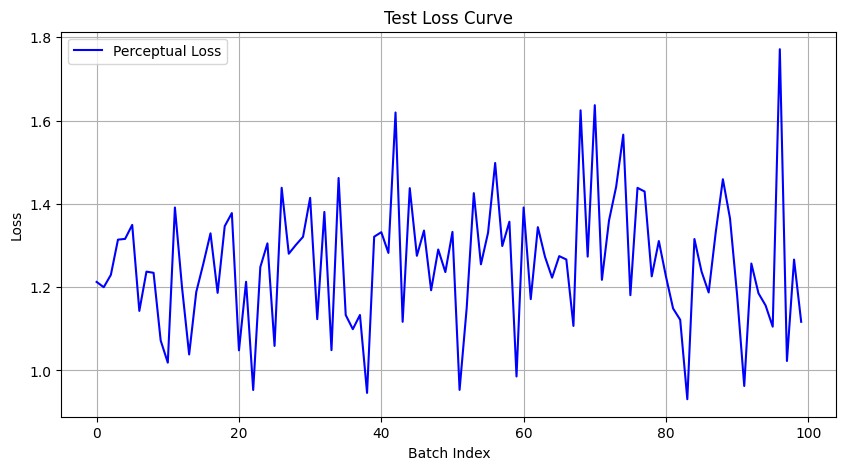

In [22]:
#Testing with plotting perceptual loss only
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19
import matplotlib.pyplot as plt  # For plotting


class Infer:
    def __init__(self, model_path, batch_size=1):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.batch_size = batch_size

        # Load the GFPGAN model
        self.netG = GFPGANv1Clean(
            out_size=512,
            num_style_feat=512,
            channel_multiplier=2,
            decoder_load_path=None,
            fix_decoder=True,
            num_mlp=8,
            input_is_latent=True,
            different_w=True,
            narrow=1,
            sft_half=True
        ).to(self.device)

        # Load the model checkpoint
        state_dict = torch.load(model_path, map_location=self.device, weights_only=False)
        self.netG.load_state_dict(state_dict['g_ema'])
        self.netG.eval()

        # Initialize Perceptual Loss
        self.perceptual_loss = PerceptualLoss(
            layer_weights={'conv5_4': 1.0},  # Example layer weights
            vgg_type='vgg19',
            use_input_norm=True,
            range_norm=False,
            perceptual_weight=1.0,
            style_weight=0.0,
            criterion='l1'
        ).to(self.device)

        # Initialize a list to store test losses
        self.test_losses = []

    def run(self, img_paths, hq_paths=None, save=None):
        """Run inference on a list of images.

        Args:
            img_paths (list): List of paths to input images.
            hq_paths (list): List of paths to ground-truth images (optional).
            save (str): Directory to save output images (optional).
        """
        if save:
            os.makedirs(save, exist_ok=True)

        num_images = len(img_paths)
        for i in range(0, num_images, self.batch_size):
            batch_lq_paths = img_paths[i:i + self.batch_size]
            batch_hq_paths = hq_paths[i:i + self.batch_size] if hq_paths else None

            # Preprocess batch
            batch_lq = torch.cat([self.preprocess(p) for p in batch_lq_paths], dim=0)
            batch_hq = torch.cat([self.preprocess(p) for p in batch_hq_paths], dim=0) if batch_hq_paths else None


            # Run inference on batch
            with torch.no_grad():
                batch_oup, _ = self.netG(batch_lq)
            # # Debug: Print input tensor size
            # print(f"I/P tensor size: {batch_lq.shape}")

            # # Debug: Print output tensor size
            # print(f"O/P tensor size: {batch_oup.shape}")

            # Calculate perceptual loss if ground-truth images are provided
            if batch_hq is not None:
                # Ensure ground-truth and output tensors have the same size
                if batch_hq.shape != batch_oup.shape:
                    batch_hq = F.interpolate(batch_hq, size=batch_oup.shape[2:], mode='bilinear', align_corners=False)
                percep_loss, _ = self.perceptual_loss(batch_oup, batch_hq)
                self.test_losses.append(percep_loss.item())  # Store the loss
                print(f"Perceptual Loss for batch {i // self.batch_size + 1}: {percep_loss.item()}")

            # Save output images
            if save:
                for j, img in enumerate(batch_oup):  # Iterate over each image in the batch
                    img_processed = self.postprocess(img)  # Postprocess each image
                    cv2.imwrite(os.path.join(save, os.path.basename(batch_lq_paths[j])), img_processed)

            print(f'\rProcessed {i + len(batch_lq_paths)}/{num_images} images', end='', flush=True)

        print("\nProcessing Complete!")

        # Plot the test loss curve
        self.plot_loss_curve()

    def preprocess(self, img):
        """Preprocess an image for model input.

        Args:
            img (str or np.ndarray): Path to the image or the image itself.

        Returns:
            torch.Tensor: Preprocessed image tensor.
        """
        if isinstance(img, str):
            img = cv2.imread(img)
        img = cv2.resize(img, (512, 512))  # Resize to expected input size
        img = img.astype(np.float32)[..., ::-1] / 127.5 - 1  # Normalize to [-1, 1]
        return torch.from_numpy(img.transpose(2, 0, 1)[np.newaxis, ...]).to(self.device)

    def postprocess(self, img):
        """Postprocess an output image tensor.

        Args:
            img (torch.Tensor): Output image tensor with shape [channels, height, width].

        Returns:
            np.ndarray: Postprocessed image in BGR format.
        """
        # Ensure the input tensor has 3 dimensions
        if img.dim() != 3:
            raise ValueError(f"Expected 3 dimensions, but got {img.dim()} dimensions")

        # Clip values to [-1, 1], permute dimensions, and convert to BGR
        img = (torch.clip(img, -1, 1).permute(1, 2, 0).cpu().numpy()[..., ::-1])
        return ((img + 1) * 127.5).astype(np.uint8)  # Denormalize to [0, 255]

    def plot_loss_curve(self):
        """Plot the test loss curve."""
        if not self.test_losses:
            print("No test losses to plot.")
            return

        plt.figure(figsize=(10, 5))
        plt.plot(self.test_losses, label="Perceptual Loss", color='blue')
        plt.xlabel("Batch Index")
        plt.ylabel("Loss")
        plt.title("Test Loss Curve")
        plt.legend()
        plt.grid(True)
        plt.show()


if __name__ == "__main__":
    # Paths
    model_path = '/content/drive/MyDrive/GFPGAN/pretrained/final.pth'
    base_lq = '/content/drive/MyDrive/GFPGAN/sample_and_results/damaged_images'
    base_hq = '/content/drive/MyDrive/GFPGAN/sample_and_results/100_samples_hq'
    save = '/content/drive/MyDrive/GFPGAN/sample_and_results/reconstructed_images'

    # Get image paths
    def get_image_paths(folder):
        return [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

    lq_paths = get_image_paths(base_lq)
    hq_paths = get_image_paths(base_hq) if base_hq else None

    # Ensure matching filenames
    lq_paths.sort()
    if hq_paths:
        hq_paths.sort()

    # Initialize and run inference
    model = Infer(model_path, batch_size=1)
    model.run(lq_paths, hq_paths, save)

standard torchvision vgg model is used here
Batch 1: Perceptual Loss = 1.2195, L1 Loss = 0.0611, Style Loss = 0.0000
Processed 1/100 imagesBatch 2: Perceptual Loss = 1.1938, L1 Loss = 0.0800, Style Loss = 0.0000
Processed 2/100 imagesBatch 3: Perceptual Loss = 1.2285, L1 Loss = 0.2347, Style Loss = 0.0000
Processed 3/100 imagesBatch 4: Perceptual Loss = 1.3105, L1 Loss = 0.1080, Style Loss = 0.0000
Processed 4/100 imagesBatch 5: Perceptual Loss = 1.3211, L1 Loss = 0.0586, Style Loss = 0.0000
Processed 5/100 imagesBatch 6: Perceptual Loss = 1.3529, L1 Loss = 0.2550, Style Loss = 0.0000
Processed 6/100 imagesBatch 7: Perceptual Loss = 1.1494, L1 Loss = 0.0621, Style Loss = 0.0000
Processed 7/100 imagesBatch 8: Perceptual Loss = 1.2446, L1 Loss = 0.1017, Style Loss = 0.0000
Processed 8/100 imagesBatch 9: Perceptual Loss = 1.2260, L1 Loss = 0.1389, Style Loss = 0.0000
Processed 9/100 imagesBatch 10: Perceptual Loss = 1.0791, L1 Loss = 0.1294, Style Loss = 0.0000
Processed 10/100 imagesBatc

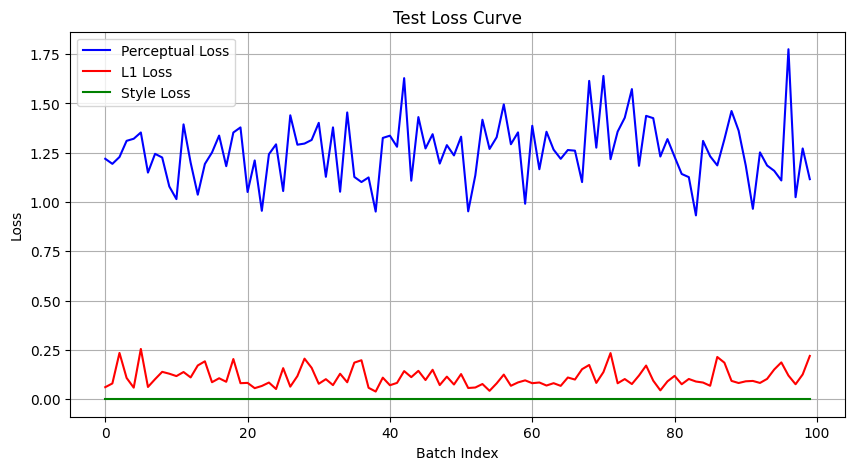

In [23]:
#Testing with plotting Perceputal loss, L1 loss and Style loss
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19
import matplotlib.pyplot as plt  # For plotting


class Infer:
    def __init__(self, model_path, batch_size=1):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.batch_size = batch_size

        # Load the GFPGAN model
        self.netG = GFPGANv1Clean(
            out_size=512,
            num_style_feat=512,
            channel_multiplier=2,
            decoder_load_path=None,
            fix_decoder=True,
            num_mlp=8,
            input_is_latent=True,
            different_w=True,
            narrow=1,
            sft_half=True
        ).to(self.device)

        # Load the model checkpoint
        state_dict = torch.load(model_path, map_location=self.device, weights_only=False)
        self.netG.load_state_dict(state_dict['g_ema'])
        self.netG.eval()

        # Initialize Perceptual Loss
        self.perceptual_loss = PerceptualLoss(
            layer_weights={'conv5_4': 1.0},  # Example layer weights
            vgg_type='vgg19',
            use_input_norm=True,
            range_norm=False,
            perceptual_weight=1.0,
            style_weight=0.0,
            criterion='l1'
        ).to(self.device)

        # Initialize L1 Loss
        self.l1_loss = nn.L1Loss().to(self.device)

        # Initialize lists to store test losses
        self.perceptual_losses = []
        self.l1_losses = []
        self.style_losses = []

    def run(self, img_paths, hq_paths=None, save=None):
        """Run inference on a list of images.

        Args:
            img_paths (list): List of paths to input images.
            hq_paths (list): List of paths to ground-truth images (optional).
            save (str): Directory to save output images (optional).
        """
        if save:
            os.makedirs(save, exist_ok=True)

        num_images = len(img_paths)
        for i in range(0, num_images, self.batch_size):
            batch_lq_paths = img_paths[i:i + self.batch_size]
            batch_hq_paths = hq_paths[i:i + self.batch_size] if hq_paths else None

            # Preprocess batch
            batch_lq = torch.cat([self.preprocess(p) for p in batch_lq_paths], dim=0)
            batch_hq = torch.cat([self.preprocess(p) for p in batch_hq_paths], dim=0) if batch_hq_paths else None

            # Run inference on batch
            with torch.no_grad():
                batch_oup, _ = self.netG(batch_lq)

            # Calculate losses if ground-truth images are provided
            if batch_hq is not None:
                # Ensure ground-truth and output tensors have the same size
                if batch_hq.shape != batch_oup.shape:
                    batch_hq = F.interpolate(batch_hq, size=batch_oup.shape[2:], mode='bilinear', align_corners=False)

                # Calculate Perceptual Loss
                percep_loss, style_loss = self.perceptual_loss(batch_oup, batch_hq)
                self.perceptual_losses.append(percep_loss.item())
                self.style_losses.append(style_loss.item() if style_loss is not None else 0.0)

                # Calculate L1 Loss
                l1_loss = self.l1_loss(batch_oup, batch_hq)
                self.l1_losses.append(l1_loss.item())

                print(f"Batch {i // self.batch_size + 1}: "
                      f"Perceptual Loss = {percep_loss.item():.4f}, "
                      f"L1 Loss = {l1_loss.item():.4f}, "
                      f"Style Loss = {style_loss.item() if style_loss is not None else 0.0:.4f}")

            # Save output images
            if save:
                for j, img in enumerate(batch_oup):  # Iterate over each image in the batch
                    img_processed = self.postprocess(img)  # Postprocess each image
                    cv2.imwrite(os.path.join(save, os.path.basename(batch_lq_paths[j])), img_processed)

            print(f'\rProcessed {i + len(batch_lq_paths)}/{num_images} images', end='', flush=True)

        print("\nProcessing Complete!")

        # Plot the test loss curve
        self.plot_loss_curve()

    def preprocess(self, img):
        """Preprocess an image for model input.

        Args:
            img (str or np.ndarray): Path to the image or the image itself.

        Returns:
            torch.Tensor: Preprocessed image tensor.
        """
        if isinstance(img, str):
            img = cv2.imread(img)
        img = cv2.resize(img, (512, 512))  # Resize to expected input size
        img = img.astype(np.float32)[..., ::-1] / 127.5 - 1  # Normalize to [-1, 1]
        return torch.from_numpy(img.transpose(2, 0, 1)[np.newaxis, ...]).to(self.device)

    def postprocess(self, img):
        """Postprocess an output image tensor.

        Args:
            img (torch.Tensor): Output image tensor with shape [channels, height, width].

        Returns:
            np.ndarray: Postprocessed image in BGR format.
        """
        # Ensure the input tensor has 3 dimensions
        if img.dim() != 3:
            raise ValueError(f"Expected 3 dimensions, but got {img.dim()} dimensions")

        # Clip values to [-1, 1], permute dimensions, and convert to BGR
        img = (torch.clip(img, -1, 1).permute(1, 2, 0).cpu().numpy()[..., ::-1])
        return ((img + 1) * 127.5).astype(np.uint8)  # Denormalize to [0, 255]

    def plot_loss_curve(self):
        """Plot the test loss curve."""
        if not self.perceptual_losses:
            print("No test losses to plot.")
            return

        plt.figure(figsize=(10, 5))
        plt.plot(self.perceptual_losses, label="Perceptual Loss", color='blue')
        plt.plot(self.l1_losses, label="L1 Loss", color='red')
        plt.plot(self.style_losses, label="Style Loss", color='green')
        plt.xlabel("Batch Index")
        plt.ylabel("Loss")
        plt.title("Test Loss Curve")
        plt.legend()
        plt.grid(True)
        plt.show()


if __name__ == "__main__":
    # Paths
    model_path = '/content/drive/MyDrive/GFPGAN/pretrained/final.pth'
    base_lq = '/content/drive/MyDrive/GFPGAN/sample_and_results/damaged_images'
    base_hq = '/content/drive/MyDrive/GFPGAN/sample_and_results/100_samples_hq'
    save = '/content/drive/MyDrive/GFPGAN/sample_and_results/reconstructed_images_feb23'

    # Get image paths
    def get_image_paths(folder):
        return [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

    lq_paths = get_image_paths(base_lq)
    hq_paths = get_image_paths(base_hq) if base_hq else None

    # Ensure matching filenames
    lq_paths.sort()
    if hq_paths:
        hq_paths.sort()

    # Initialize and run inference
    model = Infer(model_path, batch_size=1)
    model.run(lq_paths, hq_paths, save)

In [ ]:
#Inference.py

#TRY RUNNING THIS SEGMENT
import os
import numpy as np
import cv2
import torch


class Infer:
    def __init__(self,model_path):
        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = 'cuda'
        self.netG = GFPGANv1Clean(out_size=512,
                                channel_multiplier=2,
                                fix_decoder=False,
                                input_is_latent=True,
                                different_w=True,
                                sft_half=True
                                ).to(self.device)
        self.netG.load_state_dict(torch.load(model_path)['g_ema'])
        self.netG.eval()

    def run(self,img_paths,save):
        os.makedirs(save,exist_ok=True)
        for i,img_path in enumerate(img_paths):
            self.run_single(img_path,save)
            print('\rhave done %06d'%i,end='',flush=True)
        print()

    def run_single(self,img_path,save):

        inp = self.preprocess(img_path)
        with torch.no_grad():
            oup,_ = self.netG(inp,)
        oup = self.postprocess(oup)
        cv2.imwrite(os.path.join(save,os.path.basename(img_path)),oup)

    def preprocess(self,img):
        if isinstance(img,str):
            img = cv2.imread(img)
        img = cv2.resize(img,(512,512))
        img = img.astype(np.float32)[...,::-1] / 127.5 - 1
        return torch.from_numpy(img.transpose(2,0,1)[np.newaxis,...]).to(self.device)

    def postprocess(self,img):

        return (torch.clip(img,-1,1)[0].permute(1,2,0).cpu().numpy()[...,::-1]+1)*127.5


if __name__ == "__main__":
    model_path = '/content/drive/MyDrive/GFPGAN/pretrained/final.pth'
    base_lq = '/content/drive/MyDrive/GFPGAN/sample_and_results/personal_imgs'
    model = Infer(model_path)

    def get_image_paths(folder):
      return [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

    img_paths = get_image_paths(base_lq)

    save =  '/content/drive/MyDrive/GFPGAN/sample_and_results/personal_imgs_output'
    model.run(img_paths,save)

<ipython-input-24-e6a80346e78b>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.netG.load_state_dict(torch.load(model_path)['g_ema'])


have done 000003

#down_upto here


In [ ]:
#Training Loop WITH Visualization
import torch
import matplotlib.pyplot as plt
import random
import os
from tqdm import tqdm
from torchvision.utils import save_image

# Optimizer
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# Track losses and accuracy
batch_losses = []
epoch_losses = []
epoch_accuracies = []

num_epochs = 10
batch_size = 10
checkpoint_dir = "/content/drive/MyDrive/GFPGAN/checkpoints"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Training Loop
#epoch loop starts
for epoch in range(num_epochs):
    print(f"\n Starting Epoch {epoch+1}/{num_epochs}")

    # Manually Load the Latest Checkpoint
    checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')])

    if checkpoint_files:
        latest_checkpoint = os.path.join(checkpoint_dir, checkpoint_files[-1])
        print(f"Loading latest checkpoint: {latest_checkpoint}")
        checkpoint = torch.load(latest_checkpoint, map_location=device)

        # Load model state_dict
        if 'params_ema' in checkpoint:
            model.load_state_dict(checkpoint['params_ema'], strict=False)
        else:
            model.load_state_dict(checkpoint, strict=False)

        print(f"✅ Loaded Checkpoint: {latest_checkpoint}")

    else:
        print("⚠️ No previous checkpoint found, training from scratch.")

    model.train()
    epoch_loss = 0.0
    batch_loss_list = []

    tqdm_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch {epoch+1}/{num_epochs}")

    last_batch_images = None  # Store the last batch for visualization

    # Batch loop starts within the Epoch
    for idx, (lq, hq) in tqdm_bar:
        lq, hq = lq.to(device), hq.to(device)

        optimizer.zero_grad()

        # Forward pass
        reconstructed, _ = model(lq)

        # Compute losses
        loss_recon = recon_loss(reconstructed, hq)
        loss_total = loss_recon  # Add perceptual loss if needed

        # Backward pass
        loss_total.backward()
        optimizer.step()

        # Store batch loss
        batch_losses.append(loss_total.item())
        batch_loss_list.append(loss_total.item())
        epoch_loss += loss_total.item()

        # Update progress bar
        tqdm_bar.set_postfix({"Batch Loss": loss_total.item()})

        # Store last batch for visualization
        last_batch_images = (lq, reconstructed, hq)

    # Store epoch loss
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    epoch_losses.append(avg_epoch_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_epoch_loss:.4f}')


    # Save checkpoint at the end of each epoch
    checkpoint_path = f"/content/drive/MyDrive/GFPGAN/checkpoints/Clean_model_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Model checkpoint saved at: {checkpoint_path}")



    ### SHOW IMAGE IN COLAB FOR LAST BATCH ###
    if last_batch_images is not None:
        lq, reconstructed, hq = last_batch_images

        # Randomly select one image from the last batch
        random_idx = random.randint(0, lq.size(0) - 1)
        lq_img = lq[random_idx].unsqueeze(0)
        rec_img = reconstructed[random_idx].unsqueeze(0)
        hq_img = hq[random_idx].unsqueeze(0)

        ### SHOW ALL IMAGES IN LAST BATCH & SAVE TO DRIVE ###
    if last_batch_images is not None:
        lq, reconstructed, hq = last_batch_images

        os.makedirs('/content/drive/MyDrive/GFPGAN/results/', exist_ok=True)
        for i in range(batch_size):  # Save all images in last batch
            lq_img = lq[i].unsqueeze(0)
            rec_img = reconstructed[i].unsqueeze(0)
            hq_img = hq[i].unsqueeze(0)

            output_path = f'/content/drive/MyDrive/GFPGAN/results/epoch_{epoch+1}_image_{i}.jpg'
            comparison = torch.cat((lq_img, rec_img, hq_img))
            save_image(comparison, output_path)

        # Display a random image from last batch
        random_idx = random.randint(0, batch_size - 1)
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        import torchvision.transforms as transforms
        to_pil = transforms.ToPILImage()

        axes[0].imshow(to_pil(lq[random_idx].cpu()))
        axes[0].set_title("Low-Quality Input")
        axes[1].imshow(to_pil(reconstructed[random_idx].cpu()))
        axes[1].set_title("Reconstructed Output")
        axes[2].imshow(to_pil(hq[random_idx].cpu()))
        axes[2].set_title("Ground Truth")
        plt.show()

    ### ACCURACY CALCULATION ###
    with torch.no_grad():
        accuracy = 100 - (avg_epoch_loss * 100)  # Approximate accuracy
        epoch_accuracies.append(accuracy)

# PLOT LOSS CURVE SEPARATELY
plt.figure(figsize=(10, 5))
plt.plot(batch_losses, label="Batch Loss", alpha=0.5, color='blue')
plt.plot([i * len(train_dataloader) for i in range(num_epochs)], epoch_losses, label="Epoch Loss", marker='o', color='red')
plt.xlabel("Batches / Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title("Training Loss Curve")
plt.grid()
plt.show()

# PLOT ACCURACY CURVE SEPARATELY
plt.figure(figsize=(10, 5))
plt.plot([i for i in range(1, num_epochs+1)], epoch_accuracies, label="Epoch Accuracy", marker='s', linestyle='--', color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(loc='upper left')
plt.title("Training Accuracy Curve")
plt.grid()
plt.show()

In [ ]:
#Testing

import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.utils import save_image
# from gfpgan.archs.gfpganv1_clean_arch import GFPGANv1Clean

# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paths to fine-tuned model & Test Dataset
final_model_path = "/content/drive/MyDrive/GFPGAN/fine_tuned_model/final_gfpgan.pth"
hq_folder = '/content/drive/MyDrive/GFPGAN/dataset/test/high_quality/hq_images_test'
lq_folder = '/content/drive/MyDrive/GFPGAN/dataset/test/low_quality/lq_images_test'  # Low-quality images
batch_size = 10


# Initialize Model
model = GFPGANv1Clean(out_size=512, num_style_feat=512).to(device)

# Load the Final Fine-Tuned Model
if os.path.exists(final_model_path):
    print(f"Loading final fine-tuned model from: {final_model_path}")
    model.load_state_dict(torch.load(final_model_path, map_location=device))
else:
    raise FileNotFoundError(f"Final fine-tuned model not found at {final_model_path}")


model.eval()

# Load Test Dataset
test_dataloader = DataLoader(HighLowQualityDataset(hq_folder, lq_folder, transform=transform), batch_size=batch_size)

# Initialize Metrics
test_losses = []
accuracies = []

# Testing Loop with Loss and Accuracy Tracking
with torch.no_grad():
    for lq, hq in test_dataloader:
        lq, hq = lq.to(device), hq.to(device)

        # Forward Pass
        reconstructed, _ = model(lq)

        # Compute Loss
        loss = recon_loss(reconstructed, hq)
        test_losses.append(loss.item())

        # Compute Accuracy (1 - Normalized Loss)
        accuracy = 100 - (loss.item() * 100)
        accuracies.append(accuracy)

print(f'Average Test Loss: {sum(test_losses)/len(test_losses):.4f}')
print(f'Average Test Accuracy: {sum(accuracies)/len(accuracies):.2f}%')

# Plot Test Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(test_losses, label="Test Loss", color='red')
plt.xlabel("Test Samples")
plt.ylabel("Loss")
plt.title("Test Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# Plot Test Accuracy Curve
plt.figure(figsize=(8, 5))
plt.plot(accuracies, label="Test Accuracy (%)", color='green')
plt.xlabel("Test Samples")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy Curve")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#INFERENCE CODE

import os
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import save_image
from gfpgan.archs.gfpganv1_clean_arch import GFPGANv1Clean
from collections import OrderedDict

# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Path to Final Fine-Tuned Model
# final_model_path = "/content/drive/MyDrive/GFPGAN/fine_tuned_model/pretrained_GFPGANv1.3.pth"
final_model_path = "/content/drive/MyDrive/GFPGAN/fine_tuned_model/final_gfpgan.pth"

# Initialize Model
model = GFPGANv1Clean(out_size=512, num_style_feat=512).to(device)

# # Load the Final Fine-Tuned Model
if os.path.exists(final_model_path):
    print(f"Loading final fine-tuned model from: {final_model_path}")
    model.load_state_dict(torch.load(final_model_path, map_location=device))
else:
    raise FileNotFoundError(f"Final fine-tuned model not found at {final_model_path}")


# alternative code to load the Original GFPGAN and to handle the architecture mismatch##
# Load the Final Fine-Tuned Model
# if os.path.exists(final_model_path):
#     print(f"Loading final fine-tuned model from: {final_model_path}")

#     # Load the state_dict
#     state_dict = torch.load(final_model_path, map_location=device)

#     # Remove unexpected keys
#     if 'params_ema' in state_dict:
#         del state_dict['params_ema']

#     # Load with strict=False, but warn about mismatches
#     missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)

#     # Print warnings if there are mismatched keys
#     if missing_keys:
#         print(f"Missing keys in the checkpoint: {missing_keys}")
#     if unexpected_keys:
#         print(f"Unexpected keys in the checkpoint: {unexpected_keys}")

#     print("Model loaded successfully with adjustments.")

# else:
#     raise FileNotFoundError(f"Final fine-tuned model not found at {final_model_path}")


model.eval()

# Inference Function
def run_inference(image_path, output_folder):
    """Perform inference on a single image using the fine-tuned model."""

    # Define Transformations
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load and preprocess the input image
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Generate output
    with torch.no_grad():
        output_tensor, _ = model(input_tensor)

    # Convert back to PIL image
    to_pil = transforms.ToPILImage()
    input_image = to_pil(input_tensor.squeeze(0).cpu().clamp(0, 1))
    output_image = to_pil(output_tensor.squeeze(0).cpu().clamp(0, 1))

    # Save the output in Google Drive
    os.makedirs(output_folder, exist_ok=True)
    output_image_path = os.path.join(output_folder, os.path.basename(image_path))
    output_image.save(output_image_path)

    print(f"Inference completed. Output saved at: {output_image_path}")

    # Display images inline
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(input_image)
    axes[0].set_title("Low-Quality Input")
    axes[0].axis("off")

    axes[1].imshow(output_image)
    axes[1].set_title("Reconstructed Output")
    axes[1].axis("off")

    plt.show()

# Example Usage
input_image_path = "/content/drive/MyDrive/GFPGAN/dataset/inference_input_images/gfp_input_image.png"
output_folder = "/content/drive/MyDrive/GFPGAN/results/inference_results"
run_inference(input_image_path, output_folder)
